In [ ]:
import numpy as np
from collections import deque
from scipy.stats import poisson, geom
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
from scipy.sparse.linalg import eigsh
from scipy.cluster.hierarchy import DisjointSet
import timeit
import math

class Network(object):
    def __init__(self, num_nodes, adj_matrix=None):
        self.num_nodes = num_nodes
        self.adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    def add_edge(self, i, j):
        if i < self.num_nodes and j < self.num_nodes and i!=j:
          self.adj_matrix[i, j] = 1
          self.adj_matrix[j, i] = 1

    def add_edges_from_list(self, list):
      for item in list:
        if item[0] < self.num_nodes and item[1] < self.num_nodes and item[0]!=item[1]:
          self.adj_matrix[item[0], item[1]] = 1
          self.adj_matrix[item[1], item[0]] = 1

    def remove_edge(self, i, j):
        if i < self.num_nodes and j < self.num_nodes:
            self.adj_matrix[i, j] = 0
            self.adj_matrix[j, i] = 0

    def add_edges_from_adjacency_matrix(self, matrix):
        if matrix.shape == self.adj_matrix.shape and self.is_symmetric(matrix):
            np.fill_diagonal(matrix, 0)  # Ensure no self-loops
            self.adj_matrix = (self.adj_matrix | matrix).astype(int)
        else:
            raise ValueError("Input matrix must be symmetric and of the correct shape.")

    def set_connections_from_adjacency_matrix(self, matrix):
        if matrix.shape == self.adj_matrix.shape and self.is_symmetric(matrix):
            np.fill_diagonal(matrix, 0)  # Ensure no self-loops
            self.adj_matrix = matrix.copy()
        else:
            raise ValueError("Input matrix must be symmetric and of the correct shape.")

    def get_adjacency_matrix(self):
        return self.adj_matrix

    def is_symmetric(self, matrix):
        return np.array_equal(matrix, matrix.T)

    def neighbors(self, i):
        return np.where(self.adj_matrix[i] == 1)[0]

    def edge_list(self):
        edges = np.transpose(np.where(np.triu(self.adj_matrix, k=1) == 1))
        return [tuple(edge) for edge in edges]

    def mean_degree(self):
        degrees = np.sum(self.adj_matrix, axis=1)
        mean_deg = np.mean(degrees)
        return mean_deg

    def degrees(self):
        degrees = np.sum(self.adj_matrix, axis=1)
        return degrees.tolist()

    def reachable_nodes(self, start_node):
        n = self.adj_matrix.shape[0]
        visited = np.zeros(n, dtype=bool)
        reachable = []
        queue = deque([start_node])
        visited[start_node] = True
        while queue:
            node = queue.popleft()
            reachable.append(node)
            for neighbor in range(n):
                if self.adj_matrix[node, neighbor] == 1 and not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor)
        return reachable

    def average_neighbor_degrees(self):
        degrees = self.degrees()
        avg_neighbor_degrees = []
        for i in range(len(degrees)):
            neighbors = np.where(self.adj_matrix[i] == 1)[0]
            if len(neighbors) > 0:
                avg_neighbor_degree = np.mean([degrees[neighbor] for neighbor in neighbors])
            else:
                avg_neighbor_degree = np.nan
            avg_neighbor_degrees.append(avg_neighbor_degree)

        return avg_neighbor_degrees

    def compute_deltas(self):
        degrees = self.degrees()
        avg_neighbor_degrees = self.average_neighbor_degrees()
        deltas = [avg_neighbor_degrees[i] - degrees[i] for i in range(len(degrees)) if not np.isnan(avg_neighbor_degrees[i]) and degrees[i] != 0]
        return deltas

    def friendship_paradox(self, num_samples=1000):
        degrees = self.degrees()
        neighbors_degrees = []

        for _ in range(num_samples):
            random_node = random.randint(0, self.num_nodes)
            neighbors = np.where(self.adj_matrix[random_node] == 1)[0]

            if len(neighbors) > 0:
                random_neighbor = random.choice(neighbors)
                neighbors_degrees.append(degrees[random_neighbor])

        return neighbors_degrees


    def vaccinate_nodes(self, vaccination_probability):
        num_nodes = self.num_nodes
        num_vaccinated = int(num_nodes * vaccination_probability)

        vaccinated_nodes = random.sample(range(num_nodes), num_vaccinated)
        adj = self.adj_matrix
        for node in vaccinated_nodes:
            adj[node, :] = 0
            adj[:, node] = 0

        return adj

    def vaccinate_nodes_remove(self, vaccination_probability):
        num_vaccinated = int(self.num_nodes * vaccination_probability)
        vaccinated_nodes = set(random.sample(range(self.num_nodes), num_vaccinated))

        mask = [i for i in range(self.num_nodes) if i not in vaccinated_nodes]

        new_adj_matrix = self.adj_matrix[np.ix_(mask, mask)]

        return new_adj_matrix, vaccinated_nodes

    def vaccinate_friends_remove(self, vaccination_probability):
        num_to_vaccinate = int(self.num_nodes * vaccination_probability)
        num_vaccinated = 0
        vaccinated = []
        degrees = self.degrees()
        while num_vaccinated!=num_to_vaccinate:
            random_node = random.randint(0, len(degrees) - 1)
            neighbors = np.where(self.adj_matrix[random_node] == 1)[0]
            if len(neighbors) > 0:
                random_neighbor = random.choice(neighbors)
                if random_neighbor not in vaccinated:
                    vaccinated.append(random_neighbor)
                    num_vaccinated+=1

        vaccinated_set = set(vaccinated)
        mask = [i for i in range(self.num_nodes) if i not in vaccinated]
        new_adj_matrix = self.adj_matrix[np.ix_(mask, mask)]

        return new_adj_matrix

    def remove_random_connections(self, num_to_remove):
            for _ in range(num_to_remove):
                while True:
                    node = random.randint(0, self.num_nodes - 1)
                    connections = self.neighbors(node)
                    if len(connections) > 0:
                        break

                connection_to_remove = random.choice(connections)

                self.remove_edge(node, connection_to_remove)


    def remove_random_connections_friends(self, num_to_remove):
        for _ in range(num_to_remove):
            while True:
                node = random.randint(0, self.num_nodes - 1)
                neighbors = self.neighbors(node)
                if neighbors.size > 0:
                    break

            neighbor = random.choice(neighbors)

            neighbor_connections = self.neighbors(neighbor)

            connection_to_remove = random.choice(neighbor_connections)
            self.remove_edge(neighbor, connection_to_remove)



    def weighted_random_choice(self, weights):
        total = sum(weights)
        r = random.uniform(0, total)
        upto = 0
        for i, w in enumerate(weights):
            if upto + w >= r:
                return i
            upto += w
        assert False, "Shouldn't get here"

    def remove_random_connections_weighted(self, num_to_remove, pow=1):
        degrees = self.degrees()
        for _ in range(num_to_remove):

            node = self.weighted_random_choice([deg ** pow for deg in degrees])


            neighbors = self.neighbors(node)
            if neighbors.size > 0:

                neighbor = random.choice(neighbors)
                self.adj_matrix[node][neighbor] = 0
                self.adj_matrix[neighbor][node] = 0
                degrees[node] -=1
                degrees[neighbor] -=1


    def calculate_assortativity(self):
        G = nx.from_numpy_array(self.adj_matrix)
        return nx.degree_assortativity_coefficient(G)



In [ ]:

def generate_gnp_random_graph(n, p):
    if p == 1.0:
        adjacency_matrix = np.ones((n, n)) - np.eye(n)
    else:
        upper_tri = np.triu((np.random.rand(n, n) < p).astype(int), 1)
        adjacency_matrix = upper_tri + upper_tri.T
    return adjacency_matrix

def generate_gnp_random_graph_slow(n, p):
    adjacency_matrix = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    return adjacency_matrix


def generate_gnp_random_graph_with_binomial(n, p):
    max_edges = n * (n - 1) // 2
    m = np.random.binomial(max_edges, p)
    selected_edges = set()
    while len(selected_edges) < m:
        i = random.randint(0, n-1)
        j = random.randint(0, n-1)
        if i != j:
            edge = tuple(sorted((i, j)))
            selected_edges.add(edge)
    adjacency_matrix = np.zeros((n, n), dtype=int)
    for i, j in selected_edges:
        adjacency_matrix[i, j] = 1
        adjacency_matrix[j, i] = 1

    return adjacency_matrix

def plot_histogram_of_edges(n, probabilities, num_bins=30, num_samples=10000, plot_theory=False):
    plt.figure(figsize=(10, 7))
    num_possible_edges = n * (n - 1) // 2
    for p in probabilities:
        edge_counts = []
        for _ in range(num_samples):
            adj_matrix = generate_gnp_random_graph(n, p)
            num_edges = np.sum(adj_matrix) // 2
            edge_counts.append(num_edges)
        plt.hist(edge_counts, alpha=0.5, label=f'p = {p}', bins=num_bins, density=True)
        if plot_theory:
            mean = p * num_possible_edges
            std_dev = np.sqrt(num_possible_edges * p * (1 - p))
            x = np.arange(int(mean - 4*std_dev), int(mean + 4*std_dev))
            y = binom.pmf(x, num_possible_edges, p)
            plt.plot(x, y, '-', label=f'Theory p = {p}')
    plt.title(f'Histogram of Number of Edges for G(n, p) for n={n} nodes')
    plt.xlabel('Number of edges')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def sample_gnp(func, n_values, p_func, num_samples=50):
    times = []
    for n in n_values:
        p = p_func(n)
        timer = timeit.Timer(lambda: func(n, p))
        time = timer.timeit(number=num_samples) / num_samples
        times.append(time)
    return times



In [ ]:
def plot_degrees_with_distribution(degrees, distribution, param , ttl='Degrees of All Nodes in the Graph with Theoretical Distribution'):
    plt.figure(figsize=(10, 6))

    max_degree = max(degrees)
    counts, bins, _ = plt.hist(degrees, bins=range(max_degree + 2), density=True, alpha=0.7, color='blue', label='Empirical Degree Distribution', align='left')

    if distribution == 'poisson':
        lambda_val = param
        theoretical_probs = [poisson.pmf(k, lambda_val) for k in range(max_degree + 1)]
        plt.plot(range(max_degree + 1), theoretical_probs, 'ro-', label=f'Poisson Distribution (λ={lambda_val})')
    elif distribution == 'geometric':
        p = param
        theoretical_probs = [geom.pmf(k+1, p) for k in range(max_degree + 1)]  # geom.pmf(k, p) gives P(X = k) for k >= 1, so use k+1
        plt.plot(range(max_degree + 1), theoretical_probs, 'ro-', label=f'Geometric Distribution (p={p:.4f})')

    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title(ttl)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def plot_histogram_friendship(degrees, neighbours_degrees, append):

    plt.figure(figsize=(12, 6))
    plt.hist(degrees, bins=range(max(degrees) + 2), alpha=0.4, label='Original Nodes', color='blue', density=True)

    plt.hist(neighbours_degrees, bins=range(max(neighbours_degrees) + 2), alpha=0.4, label='Neighbours', color='red', density=True)

    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title('Degree Distribution of Original Nodes and Their Neighbours' + append)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_deltas(deltas, no_bins=50, append=None):
    plt.figure(figsize=(12, 6))
    plt.hist(deltas, bins=no_bins, alpha=0.7, color='green', density=True)
    plt.xlabel('Δ_i')
    plt.ylabel('Density')
    plt.title('Histogram of Δ_i Values' + append)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


def gen_config(n, klis):
  S=np.array([i for i in range(n) for _ in range(klis[i])])
  S=np.random.permutation(S)
  if len(S)%2:
    S = S[:-1]
  S=S.reshape(-1, 2)
  net = Network(n)
  net.add_edges_from_list(S)
  return net

def generate_poisson_variables(n, lambda_val):
    poisson_variables = np.random.poisson(lam=lambda_val, size=n)
    return poisson_variables.tolist()

def generate_geometric_variables(n, p):
    geometric_variables = np.random.geometric(p=p, size=n) - 1
    return geometric_variables.tolist()

def calculate_geom_probability(mean):
    if mean < 0:
        raise ValueError("Mean must be a positive number.")
    p = 1 / (mean + 1)
    return p

def generate_uniform_random_numbers(count):
  random_numbers = [random.uniform(0, 1) for _ in range(count)]
  return random_numbers



In [ ]:

class SIR(object):
    def __init__(self, network):
        self.network = network
        self.states = np.zeros(network.num_nodes, dtype=int)

    def init_states(self, q):
        self.states = np.zeros(self.network.num_nodes, dtype=int)
        for node in range(self.network.num_nodes):
            if random.random() < q:
                self.states[node] = 1

    def update_states(self, infection_prob):
        new_states = self.states.copy()
        for node in range(self.network.num_nodes):
            if self.states[node] == 1:
                for neighbor in self.network.neighbors(node):
                    if self.states[neighbor] == 0 and random.random() < infection_prob:
                        new_states[neighbor] = 1
                new_states[node] = 2
        self.states = new_states

    def simulate_sir(self, infection_prob, num_steps):
        sir_history = [self.states.copy()]
        for _ in range(num_steps):
            self.update_states(infection_prob)
            sir_history.append(self.states.copy())
        return sir_history


def plot_sir_evolution(sir_history, ttl = 'SIR Model Evolution'):
    S = []
    I = []
    R = []

    for state in sir_history:
        S.append(np.sum(state == 0))
        I.append(np.sum(state == 1))
        R.append(np.sum(state == 2))

    time_steps = range(len(sir_history))

    plt.figure(figsize=(8, 5))
    plt.plot(time_steps, S, label='Susceptible')
    plt.plot(time_steps, I, label='Infected')
    plt.plot(time_steps, R, label='Recovered')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Nodes')
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()





class EfficientSIR(object):
    def __init__(self, network, infection_prob):
        self.network = network
        self.infection_prob = infection_prob
        self.disjoint_set = DisjointSet(range(network.num_nodes))
        self.initialize_infection_clusters()

    def initialize_infection_clusters(self):
        for node in range(self.network.num_nodes):
            for neighbor in self.network.neighbors(node):
                if random.random() < self.infection_prob:
                    self.disjoint_set.merge(node, neighbor)

    def average_cluster_size(self):


        cluster_sizes = [self.disjoint_set.subset_size(i) for i in range(self.network.num_nodes)]

        return np.mean(cluster_sizes), np.std(cluster_sizes)

class superEfficientSIR(object):
    def __init__(self, network, q):
        self.network = network
        self.q = q
        self.disjoint_set = DisjointSet(range(network.num_nodes))
        self.edge_list = network.edge_list()

    def average_cluster_sizes(self):
        mean_cluster_sizes = []
        std_cluster_sizes = []
        np.random.shuffle(self.edge_list)


        for i in range(0, len(self.edge_list), self.q):
            chunk = self.edge_list[i:i+self.q]
            for edge in chunk:
                self.disjoint_set.merge(edge[0], edge[1])

            cluster_sizes = [self.disjoint_set.subset_size(j) for j in range(self.network.num_nodes)]
            mean_cluster_sizes.append(np.mean(cluster_sizes))
            std_cluster_sizes.append(np.std(cluster_sizes))

        return mean_cluster_sizes, std_cluster_sizes

In [ ]:
import unittest

class TestNetwork(unittest.TestCase):
    def setUp(self):
        self.network = Network(5)

    def test_add_edge(self):
        self.network.add_edge(0, 1)
        self.network.add_edge(0, 2)
        self.network.add_edge(1, 3)
        self.network.add_edge(3, 4)

        expected_matrix = np.array([
            [0, 1, 1, 0, 0],
            [1, 0, 0, 1, 0],
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 1],
            [0, 0, 0, 1, 0]
        ])
        np.testing.assert_array_equal(self.network.get_adjacency_matrix(), expected_matrix)

    def test_remove_edge(self):
        self.network.add_edge(0, 1)
        self.network.add_edge(1, 2)
        self.network.remove_edge(0, 1)
        expected_matrix = np.array([
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]
        ])
        np.testing.assert_array_equal(self.network.get_adjacency_matrix(), expected_matrix)

    def test_set_and_modify_adjacency_matrix(self):
            initial_matrix = np.array([
                [0, 1, 0, 0, 0],
                [1, 0, 1, 0, 0],
                [0, 1, 0, 1, 0],
                [0, 0, 1, 0, 1],
                [0, 0, 0, 1, 0]
            ])
            self.network.set_connections_from_adjacency_matrix(initial_matrix)
            self.network.add_edge(0, 2)
            expected_matrix = np.array([
                [0, 1, 1, 0, 0],
                [1, 0, 1, 0, 0],
                [1, 1, 0, 1, 0],
                [0, 0, 1, 0, 1],
                [0, 0, 0, 1, 0]
            ])
            np.testing.assert_array_equal(self.network.get_adjacency_matrix(), expected_matrix)

    def test_error_on_unsymmetric_matrix(self):
        unsymmetric_matrix = np.array([
            [0, 1, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 0, 1, 0, 1],
            [0, 0, 0, 0, 0]
        ])
        with self.assertRaises(ValueError) as context:
            self.network.set_connections_from_adjacency_matrix(unsymmetric_matrix)
        self.assertTrue('Input matrix must be symmetric' in str(context.exception))
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 0.011s

OK


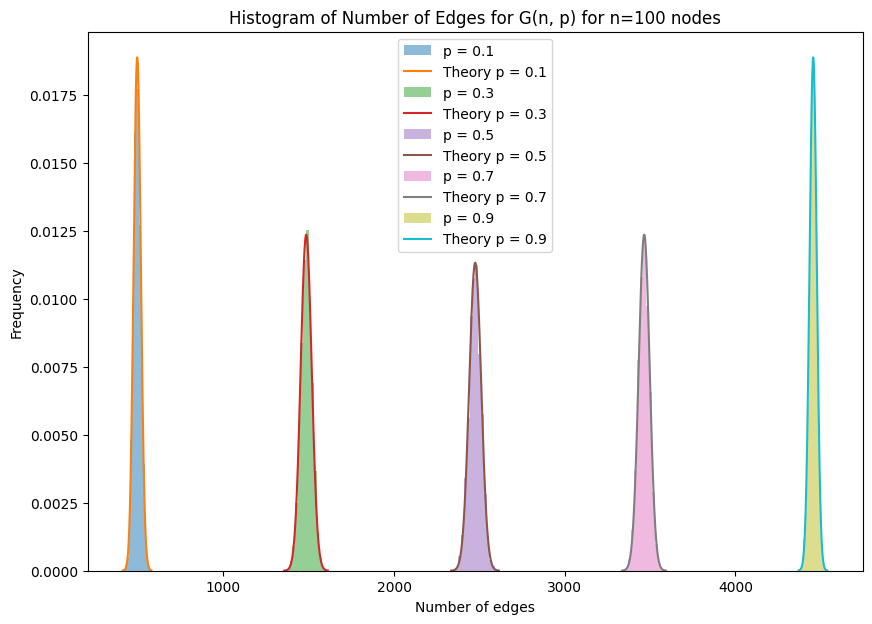

In [ ]:
# Task 1
n = 100
probabilities = [0.1, 0.3, 0.5, 0.7, 0.9]
#plot_histogram_of_edges(n, [probabilities[0]], num_bins=40, plot_theory=True)
#plot_histogram_of_edges(n, [probabilities[1]], num_bins=40, plot_theory=True)
#plot_histogram_of_edges(n, [probabilities[2]], num_bins=40, plot_theory=False)
#plot_histogram_of_edges(n, [probabilities[3]], num_bins=40, plot_theory=True)
#plot_histogram_of_edges(n, [probabilities[4]], num_bins=40, plot_theory=True)
plot_histogram_of_edges(n, probabilities, num_bins=15, plot_theory=True)


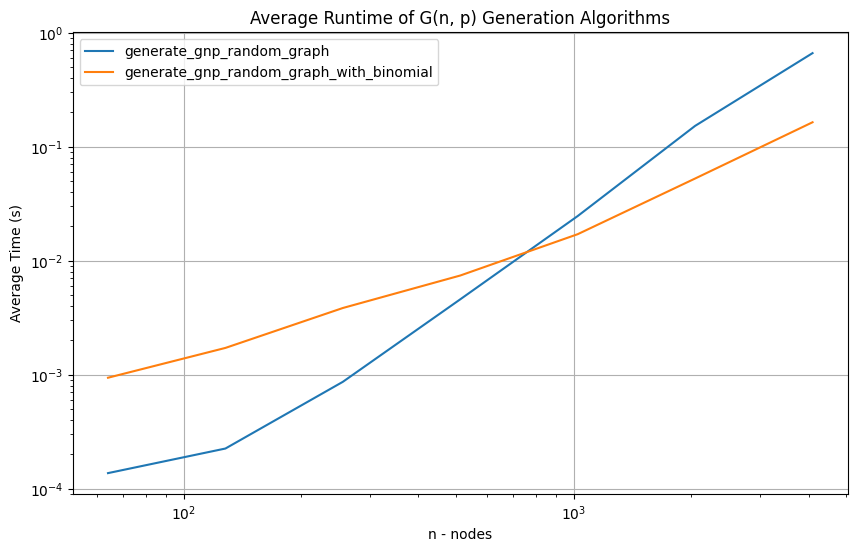

In [ ]:
n_values = [64, 128, 256, 512, 1024, 2048, 4096]
p_func = lambda n: 10 / (n - 1)

times_original = sample_gnp(generate_gnp_random_graph, n_values, p_func)
times_optimized = sample_gnp(generate_gnp_random_graph_with_binomial, n_values, p_func)

plt.figure(figsize=(10, 6))
plt.plot(n_values, times_original, label='generate_gnp_random_graph')
plt.plot(n_values, times_optimized, label='generate_gnp_random_graph_with_binomial')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('n - nodes')
plt.ylabel('Average Time (s)')
plt.title('Average Runtime of G(n, p) Generation Algorithms')
plt.legend()
plt.grid(True)
plt.show()

0.0
4.1666666666666665e-05
8.333333333333333e-05
0.000125
0.00016666666666666666
0.00020833333333333332
0.00025
0.00029166666666666664
0.0003333333333333333
0.000375
0.00041666666666666664
0.0004583333333333333
0.0005
0.0005416666666666666
0.0005833333333333333
0.000625
0.0006666666666666666
0.0007083333333333333
0.00075
0.0007916666666666666
0.0008333333333333333
0.000875
0.0009166666666666666
0.0009583333333333333
0.001


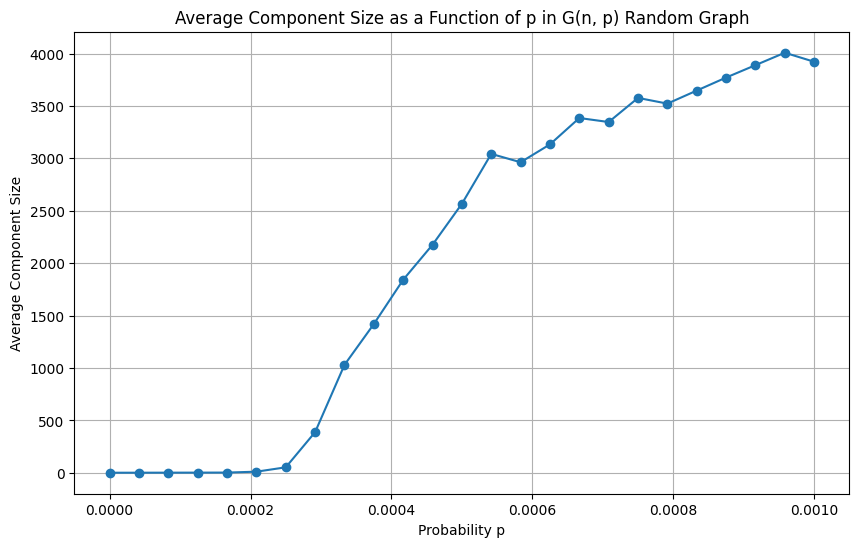

In [ ]:
num_nodes = 4096
p_values = np.linspace(0, 0.001, 25)
num_trials = 40
average_component_sizes = []

for p in p_values:
    total_size = 0
    for _ in range(num_trials):
        random_matrix = generate_gnp_random_graph_with_binomial(num_nodes, p)
        new_network = Network(num_nodes)
        new_network.set_connections_from_adjacency_matrix(random_matrix)
        component_size = len(new_network.reachable_nodes(0))
        total_size += component_size

    average_size = total_size / num_trials
    average_component_sizes.append(average_size)

plt.figure(figsize=(10, 6))
plt.plot(p_values, average_component_sizes, marker='o')
plt.xlabel('Probability p')
plt.ylabel('Average Component Size')
plt.title('Average Component Size as a Function of p in G(n, p) Random Graph')
plt.grid(True)
plt.show()

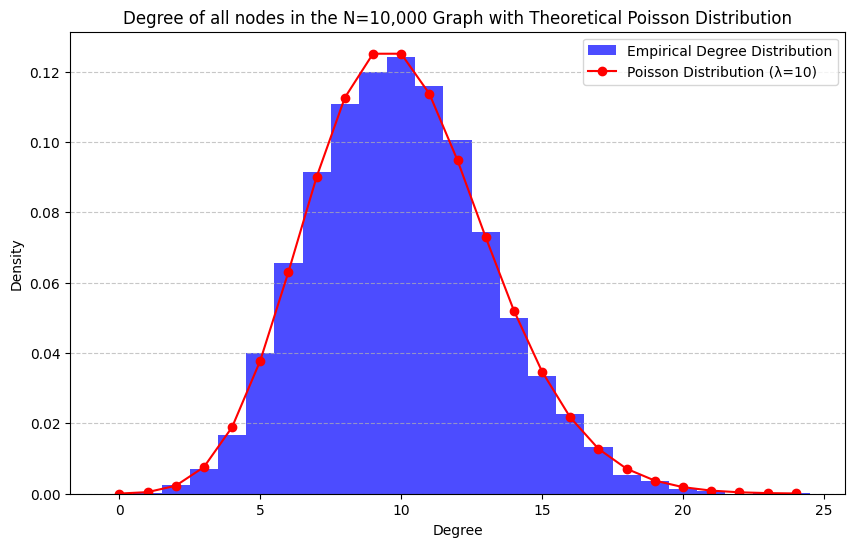

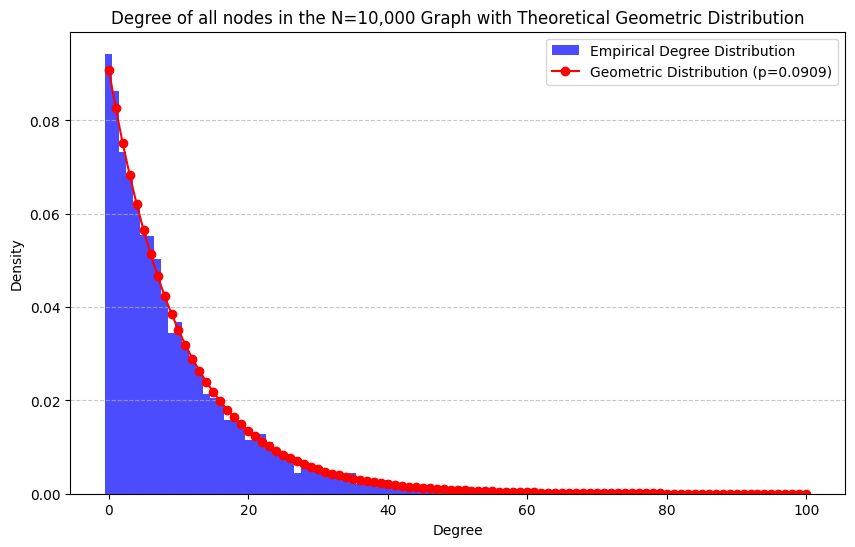

Poiss mean degree 9.9854
Geom mean degree 9.8488
Poisson neighbours mean degree 10.9613
Geometric neighbours mean degree 20.70303299633374


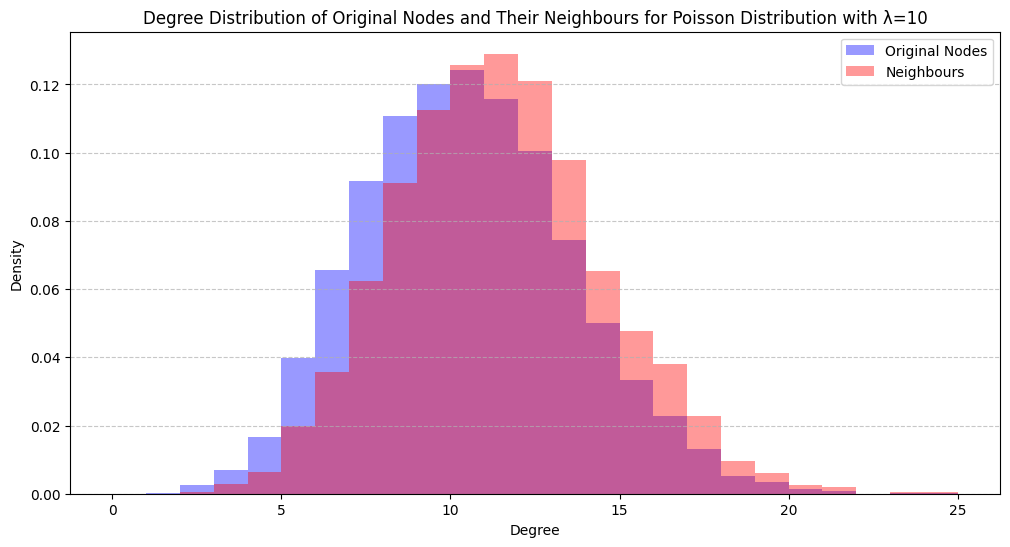

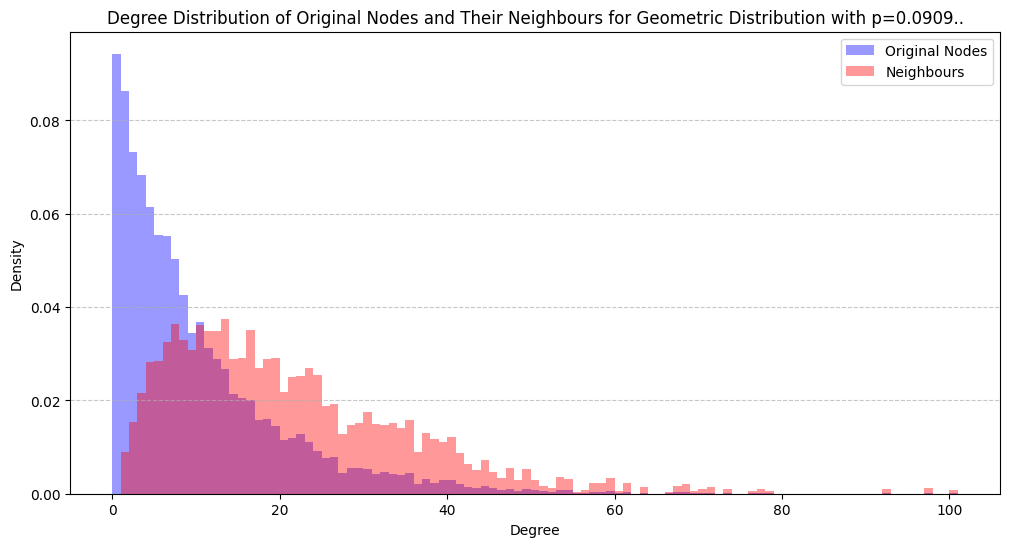

Poissons mean delta 0.9790038270608635
Geom mean delta 9.91663066531536


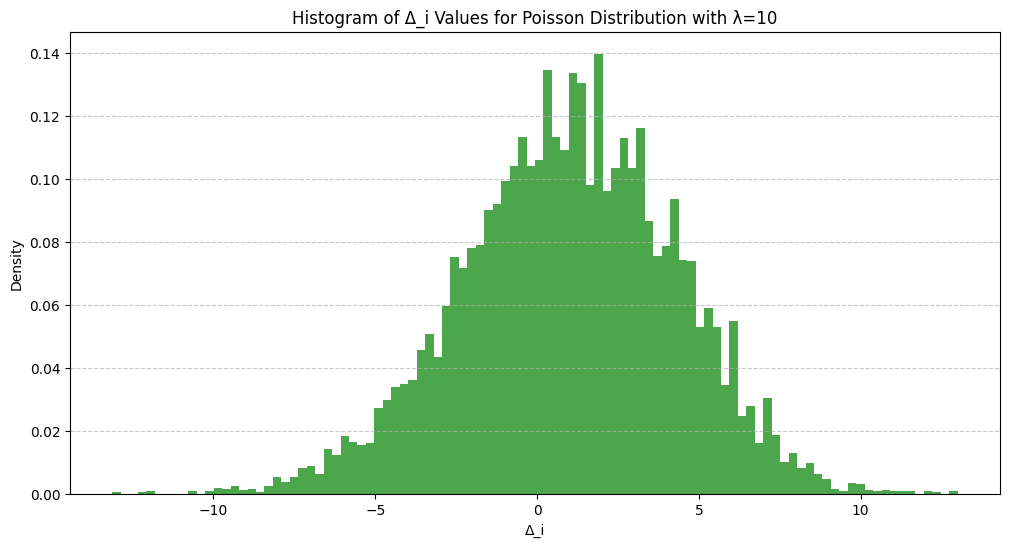

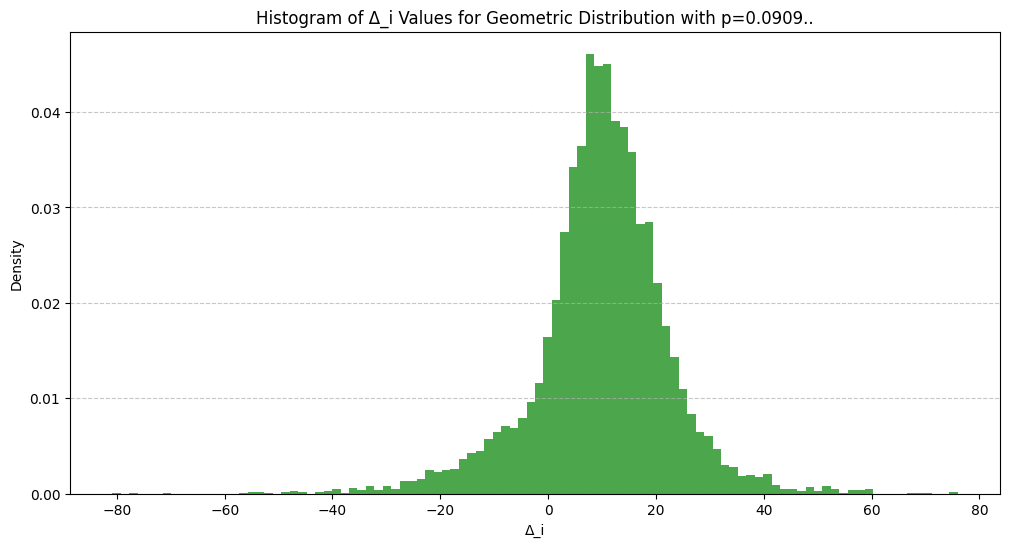

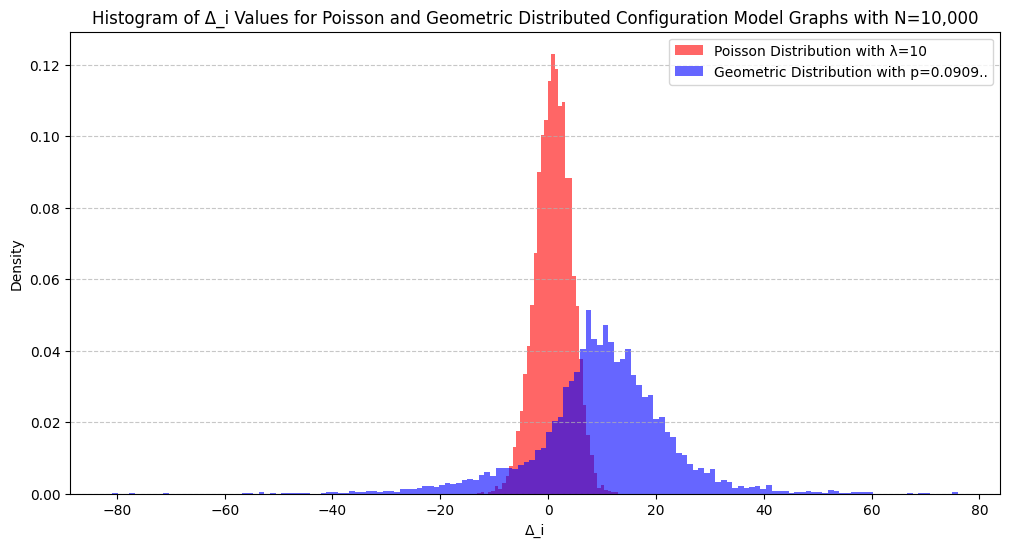

Poiss mean0.9790038270608635
Geom mean9.91663066531536


In [ ]:
klist_poiss = generate_poisson_variables(10000, 10)
klist_geom = generate_geometric_variables(10000, calculate_geom_probability(10))

net_poiss = gen_config(10000, klist_poiss)
net_geom = gen_config(10000, klist_geom)

degrees_poiss_list = net_poiss.degrees()
degrees_geom_list = net_geom.degrees()

plot_degrees_with_distribution(degrees_poiss_list, 'poisson', 10, ttl = "Degree of all nodes in the N=10,000 Graph with Theoretical Poisson Distribution")
plot_degrees_with_distribution(degrees_geom_list, 'geometric', calculate_geom_probability(10), "Degree of all nodes in the N=10,000 Graph with Theoretical Geometric Distribution")

print("Poiss mean degree " + str(net_poiss.mean_degree()))
print("Geom mean degree " + str(net_geom.mean_degree()))

neighbours_poiss_degrees_list = net_poiss.friendship_paradox(10000)
neighbours_geom_degrees_list = net_geom.friendship_paradox(10000)

print("Poisson neighbours mean degree " + str(np.nanmean(neighbours_poiss_degrees_list)))
print("Geometric neighbours mean degree " + str(np.nanmean(neighbours_geom_degrees_list)))

plot_histogram_friendship(degrees_poiss_list, neighbours_poiss_degrees_list, " for Poisson Distribution with λ=10")
plot_histogram_friendship(degrees_geom_list, neighbours_geom_degrees_list, " for Geometric Distribution with p=0.0909..")

deltas_poiss = net_poiss.compute_deltas()
deltas_geom = net_geom.compute_deltas()

print("Poissons mean delta " + str(np.mean(deltas_poiss)))
print("Geom mean delta " + str(np.mean(deltas_geom)))
plot_deltas(deltas_poiss, 100, " for Poisson Distribution with λ=10")
plot_deltas(deltas_geom, 100, " for Geometric Distribution with p=0.0909..")

plt.figure(figsize=(12, 6))
plt.hist(deltas_poiss, bins=40, alpha=0.6, color='red', density=True, label="Poisson Distribution with λ=10")
plt.hist(deltas_geom, bins=150, alpha=0.6, color='blue', density=True, label='Geometric Distribution with p=0.0909..')
plt.xlabel('Δ_i')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Δ_i Values for Poisson and Geometric Distributed Configuration Model Graphs with N=10,000')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Poiss mean" + str(np.mean(deltas_poiss)))
print("Geom mean" + str(np.mean(deltas_geom)))

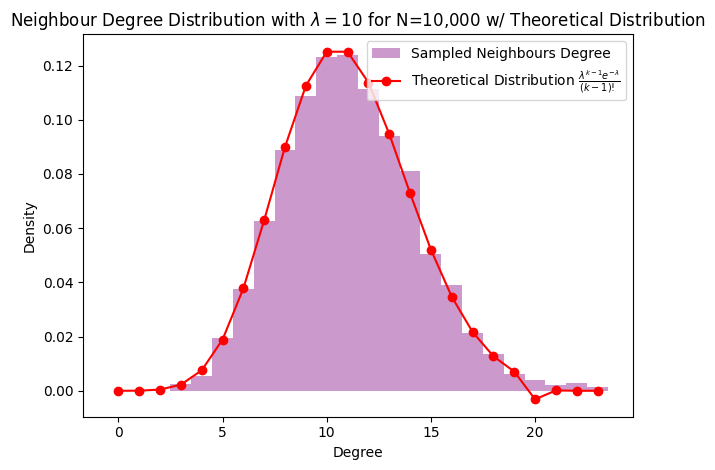

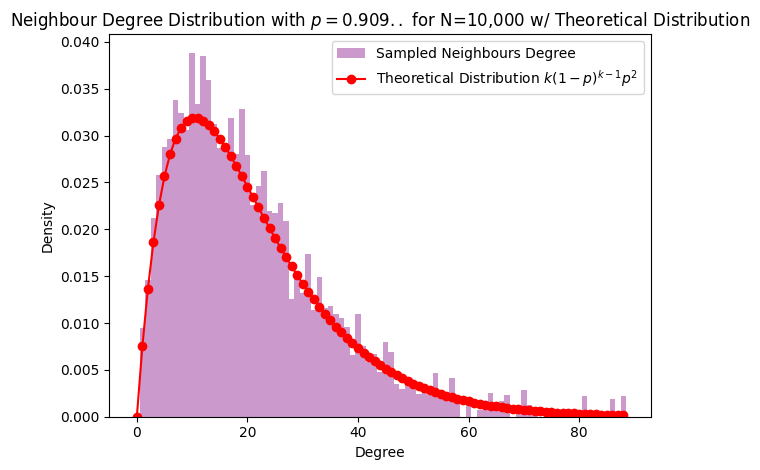

In [ ]:
lambda_val = 10


k_values = np.arange(0, max(neighbours_poiss_degrees_list) + 1)
poisson_values = [((lambda_val**(k-1)) * np.exp(-lambda_val)) / math.factorial(k-1) if k > 0 else 0 for k in k_values]


plt.hist(neighbours_poiss_degrees_list, bins=range(max(neighbours_poiss_degrees_list) + 2), alpha=0.4, label='Sampled Neighbours Degree', color='purple', density=True, align='left')

plt.plot(k_values, poisson_values, 'ro-', label=r'Theoretical Distribution $\frac{\lambda^{k-1} e^{-\lambda}}{(k-1)!}$')
plt.xlabel("Degree")
plt.ylabel("Density")
plt.title("Neighbour Degree Distribution with $\lambda = 10$ for N=10,000 w/ Theoretical Distribution")
plt.legend()
plt.tight_layout()
plt.show()

import math
geom_p = calculate_geom_probability(10)


k_values = np.arange(0, max(neighbours_geom_degrees_list) + 1)
geom_values = [k*((1-geom_p)**k)*geom_p**2 if k > 0 else 0 for k in k_values]


plt.hist(neighbours_geom_degrees_list, bins=range(max(neighbours_geom_degrees_list) + 2), alpha=0.4, label= 'Sampled Neighbours Degree', color='purple', density=True, align='left')


plt.plot(k_values, geom_values, 'ro-', label=r'Theoretical Distribution $k(1-p)^{k-1} p^2$')
plt.xlabel("Degree")
plt.ylabel("Density")
plt.title("Neighbour Degree Distribution with $p=0.909..$ for N=10,000 w/ Theoretical Distribution")
plt.legend()
plt.tight_layout()
plt.show()



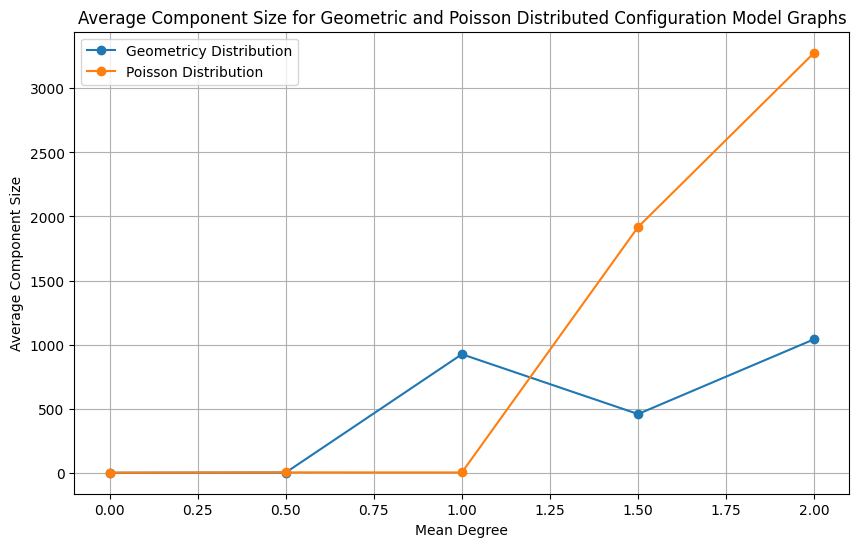

In [ ]:
num_nodes = 4096
m_values = np.linspace(0, 2, 5)
num_trials = 5
average_component_sizes_geom = []
average_component_sizes_poiss = []

for m in m_values:
    total_size_geom = 0
    total_size_poiss = 0
    for _ in range(num_trials):
        klist_geom = generate_geometric_variables(num_nodes, calculate_geom_probability(m))
        net_geom = gen_config(num_nodes, klist_geom)
        component_size_geom = len(net_geom.reachable_nodes(0))
        total_size_geom += component_size_geom

        klist_poiss = generate_poisson_variables(num_nodes, m)
        net_poiss = gen_config(num_nodes, klist_poiss)
        component_size_poiss = len(net_poiss.reachable_nodes(0))
        total_size_poiss += component_size_poiss

    average_size_geom = total_size_geom / num_trials
    average_component_sizes_geom.append(average_size_geom)

    average_size_poiss = total_size_poiss / num_trials
    average_component_sizes_poiss.append(average_size_poiss)

plt.figure(figsize=(10, 6))
plt.plot(m_values, average_component_sizes_geom, label='Geometricy Distribution', marker='o')
plt.plot(m_values, average_component_sizes_poiss, label='Poisson Distribution', marker='o')
plt.xlabel('Mean Degree')
plt.ylabel('Average Component Size')
plt.title('Average Component Size for Geometric and Poisson Distributed Configuration Model Graphs')
plt.legend()
plt.grid(True)
plt.show()

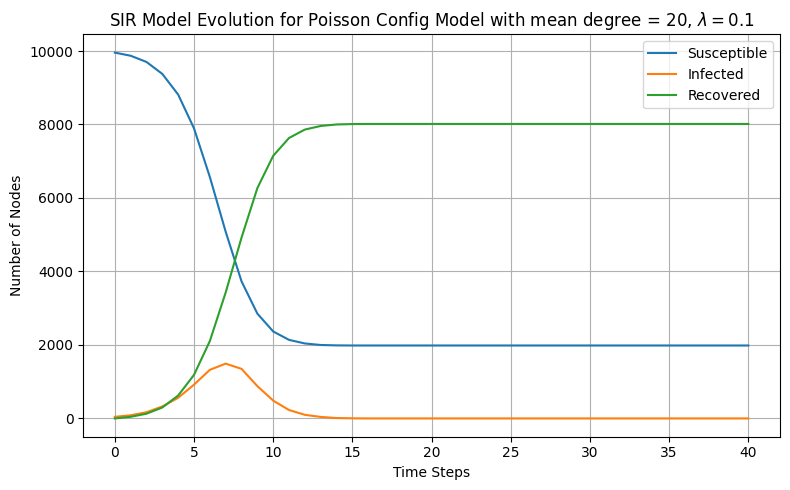

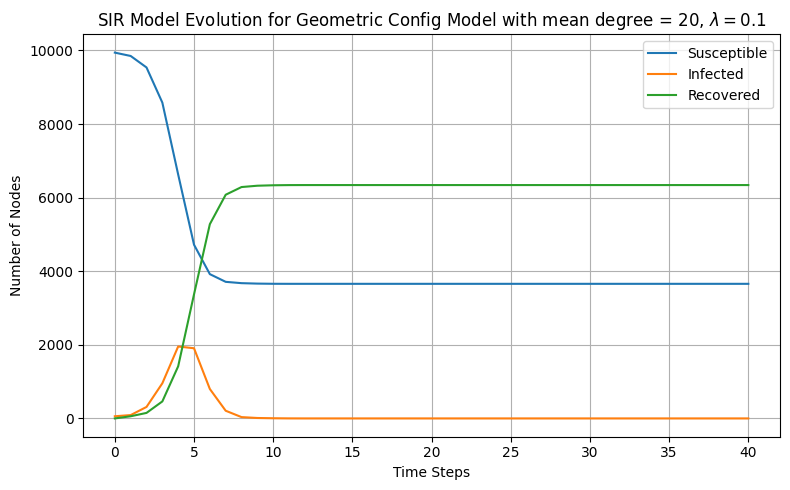

In [ ]:
klist_poiss = generate_poisson_variables(100000, 20)
klist_geom = generate_geometric_variables(100000, calculate_geom_probability(20))


net_poiss = gen_config(10000, klist_poiss)
net_geom = gen_config(10000, klist_geom)



sir_model_poiss = SIR(net_poiss)
sir_model_geom = SIR(net_geom)



q = 0.005
sir_model_poiss.init_states(q)
sir_model_geom.init_states(q)


infection_prob = 0.1
num_steps = 40
sir_history_poiss = sir_model_poiss.simulate_sir(infection_prob, num_steps)
sir_history_geom = sir_model_geom.simulate_sir(infection_prob, num_steps)



plot_sir_evolution(sir_history_poiss, "SIR Model Evolution for Poisson Config Model with mean degree = 20, $\lambda = 0.1$")
plot_sir_evolution(sir_history_geom, "SIR Model Evolution for Geometric Config Model with mean degree = 20, $\lambda = 0.1$")



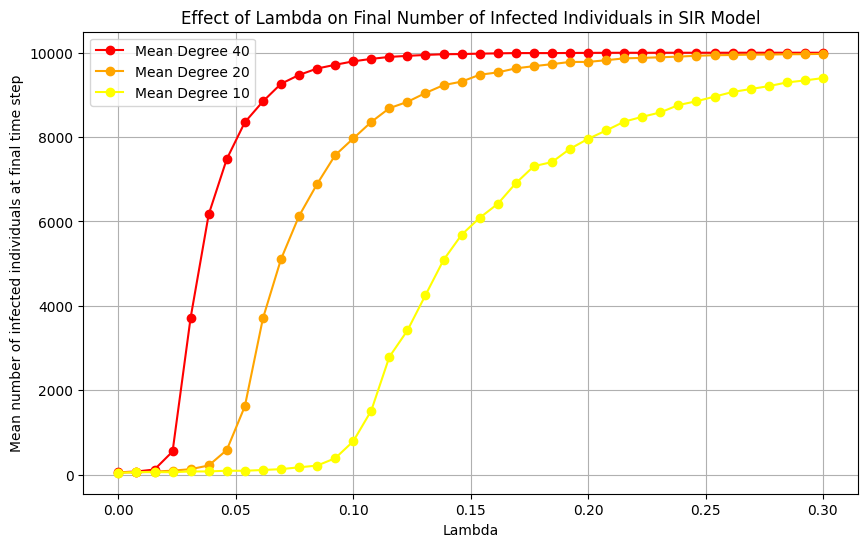

In [ ]:
num_iterations = 3
num_time_steps = 40
q=0.005
lambdas = np.linspace(0, 0.3, 40)
vals_forty = []
vals_twenty = []
vals_ten = []

klist_poiss_forty = generate_poisson_variables(10000, 40)
klist_poiss_twenty = generate_poisson_variables(10000, 20)
klist_poiss_ten = generate_poisson_variables(10000, 10)

net_poiss_forty = gen_config(10000, klist_poiss_forty)
net_poiss_twenty = gen_config(10000, klist_poiss_twenty)
net_poiss_ten = gen_config(10000, klist_poiss_ten)

sir_model_forty = SIR(net_poiss_forty)
sir_model_twenty = SIR(net_poiss_twenty)
sir_model_ten = SIR(net_poiss_ten)

for lamb in (lambdas):
  ls_forty = []
  ls_twenty = []
  ls_ten = []
  for _ in range(num_iterations):
    sir_model_forty.init_states(q)
    sir_model_twenty.init_states(q)
    sir_model_ten.init_states(q)

    sir_history_forty = sir_model_forty.simulate_sir(lamb, num_time_steps)
    sir_history_twenty = sir_model_twenty.simulate_sir(lamb, num_time_steps)
    sir_history_ten = sir_model_ten.simulate_sir(lamb, num_time_steps)

    ls_forty.append(np.sum(sir_history_forty[num_time_steps-1] == 2))
    ls_twenty.append(np.sum(sir_history_twenty[num_time_steps-1] == 2))
    ls_ten.append(np.sum(sir_history_ten[num_time_steps-1] == 2))


  vals_forty.append(np.mean(ls_forty))
  vals_twenty.append(np.mean(ls_twenty))
  vals_ten.append(np.mean(ls_ten))

plt.figure(figsize=(10, 6))
plt.plot(lambdas, vals_forty, marker='o', linestyle='-', color='red', label="Mean Degree 40")
plt.plot(lambdas, vals_twenty, marker='o', linestyle='-', color='orange', label="Mean Degree 20")
plt.plot(lambdas, vals_ten, marker='o', linestyle='-', color='yellow', label="Mean Degree 10")
plt.xlabel('Lambda')
plt.ylabel('Mean number of infected individuals at final time step')
plt.title('Effect of Lambda on Final Number of Infected Individuals in SIR Model')
plt.legend()
plt.grid(True)
plt.show()





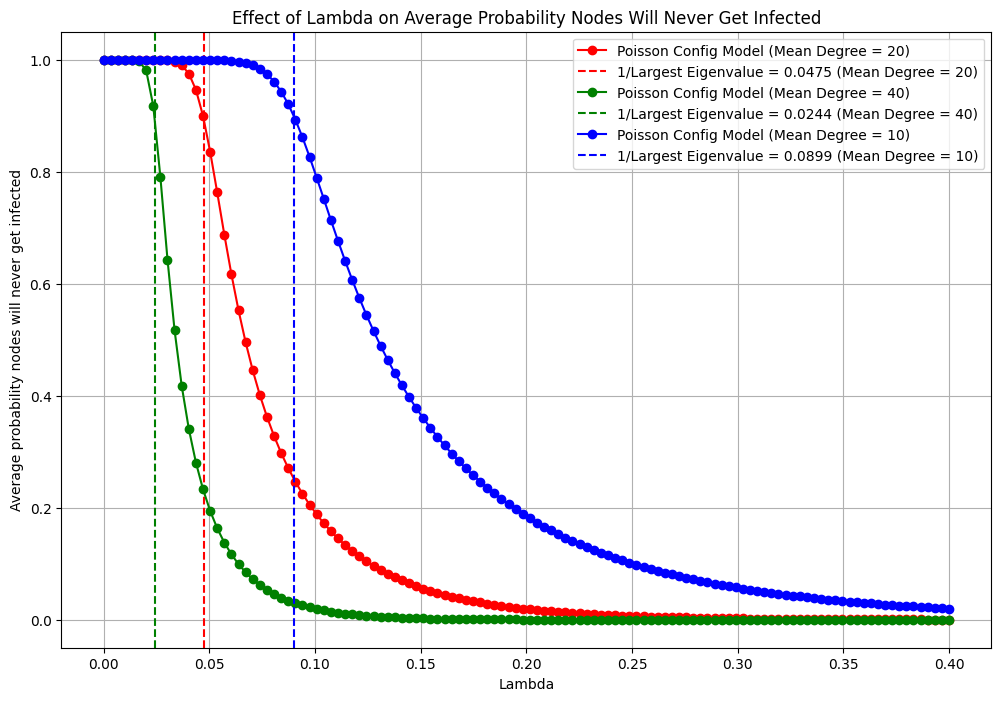

In [ ]:
def probability_nodes_never_infected(net, lambd, num_iterations=10):
    adj_matr = net.get_adjacency_matrix()
    s_vals = generate_uniform_random_numbers(net.num_nodes)
    for _ in range(num_iterations):
        for i in range(net.num_nodes):
            ctr = 1
            neighbours = net.neighbors(i)
            for neighbour in neighbours:
                ctr *= (1-lambd+s_vals[neighbour]*lambd)**adj_matr[i][neighbour]

            s_vals[i] = ctr
    return s_vals




def process_and_plot(mean_degree, color, label):
    klist_poiss = generate_poisson_variables(10000, mean_degree)
    net_poiss = gen_config(10000, klist_poiss)
    largest_eigenvalue, _ = eigsh(net_poiss.get_adjacency_matrix().astype(float), k=1, which='LA')
    largest_eigenvalue = largest_eigenvalue[0]

    lambdas = np.linspace(0, 0.4, 120)
    avg_s_vals = []
    for lambd in lambdas:
        avg_s_vals.append(np.mean(probability_nodes_never_infected(net_poiss, lambd, 7)))

    plt.plot(lambdas, avg_s_vals, marker='o', linestyle='-', color=color, label=f"{label} (Mean Degree = {mean_degree})")
    plt.axvline(x=1/largest_eigenvalue, color=color, linestyle='--', label=f'1/Largest Eigenvalue = {1/largest_eigenvalue:.4f} (Mean Degree = {mean_degree})')

plt.figure(figsize=(12, 8))


process_and_plot(20, 'red', 'Poisson Config Model')
process_and_plot(40, 'green', 'Poisson Config Model')
process_and_plot(10, 'blue', 'Poisson Config Model')

plt.xlabel('Lambda')
plt.ylabel('Average probability nodes will never get infected')
plt.title('Effect of Lambda on Average Probability Nodes Will Never Get Infected')
plt.grid()
plt.legend()
plt.show()


Initial Assortativity: -0.0022312661315557164
39.895
0.022859304814146858


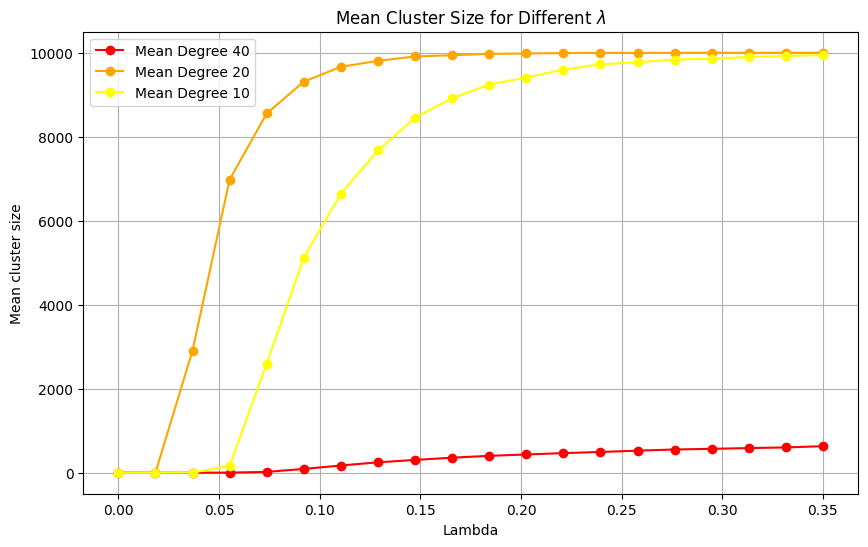

In [ ]:

num_iterations = 3
num_time_steps = 40
q=0.005
lambdas = np.linspace(0, 0.35, 20)
vals_forty = []
vals_twenty = []
vals_ten = []

klist_poiss_forty = generate_poisson_variables(10000, 40)
klist_poiss_twenty = generate_poisson_variables(10000, 20)
klist_poiss_ten = generate_poisson_variables(10000, 10)

net_poiss_forty = gen_config(10000, klist_poiss_forty)
net_poiss_twenty = gen_config(10000, klist_poiss_twenty)
net_poiss_ten = gen_config(10000, klist_poiss_ten)
for lamb in (lambdas):
  ls_forty = []
  ls_twenty = []
  ls_ten = []
  for _ in range(num_iterations):
    sir_model_forty = EfficientSIR(net_poiss_forty, lamb)
    sir_model_twenty = EfficientSIR(net_poiss_twenty, lamb)
    sir_model_ten = EfficientSIR(net_poiss_ten, lamb)

    mean_forty, _ = sir_model_forty.average_cluster_size()
    mean_twenty, _ = sir_model_twenty.average_cluster_size()
    mean_ten, _ = sir_model_ten.average_cluster_size()

    ls_forty.append(mean_forty)
    ls_twenty.append(mean_twenty)
    ls_ten.append(mean_ten)


  vals_forty.append(np.mean(ls_forty))
  vals_twenty.append(np.mean(ls_twenty))
  vals_ten.append(np.mean(ls_ten))

plt.figure(figsize=(10, 6))
plt.plot(lambdas, vals_forty, marker='o', linestyle='-', color='red', label="Mean Degree 40")
plt.plot(lambdas, vals_twenty, marker='o', linestyle='-', color='orange', label="Mean Degree 20")
plt.plot(lambdas, vals_ten, marker='o', linestyle='-', color='yellow', label="Mean Degree 10")
plt.xlabel('Lambda')
plt.ylabel('Mean cluster size')
plt.title('Mean Cluster Size for Different $\lambda$')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

klist_poiss_twenty = generate_poisson_variables(10000, 20)
net_poiss_twenty = gen_config(10000, klist_poiss_twenty)
sir = superEfficientSIR(net_poiss_twenty, 30)
means, std = sir.average_cluster_sizes()

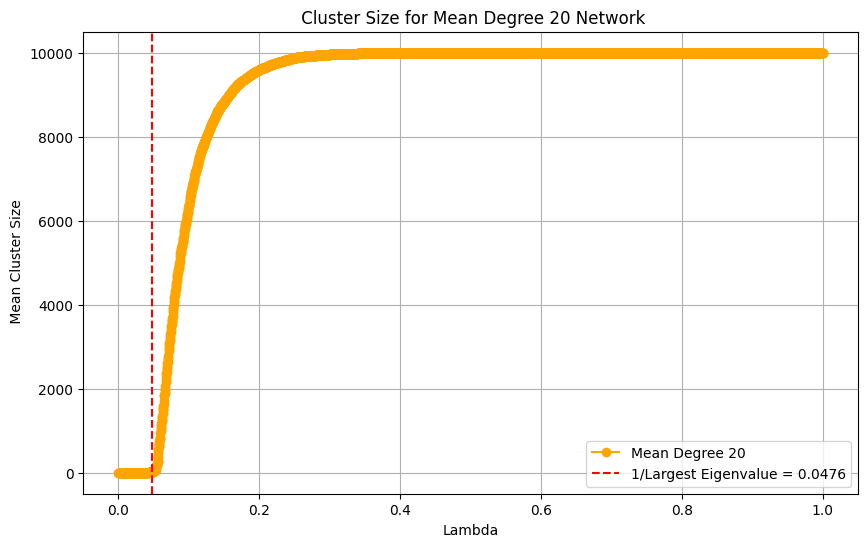

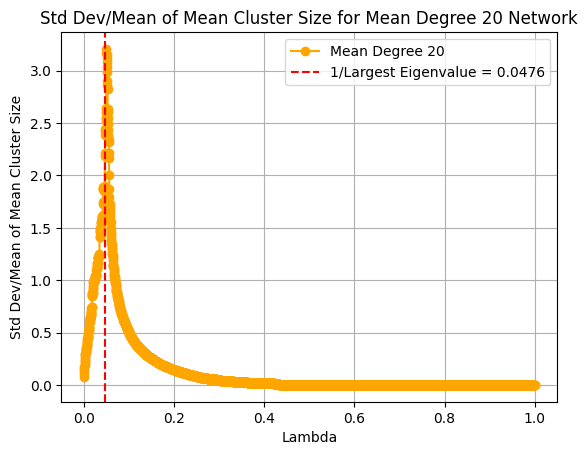

In [ ]:
num_edges = len(net_poiss_twenty.edge_list())
lambdas = np.linspace(0, 1, num_edges//30+1)

plt.figure(figsize=(10, 6))

largest_eigenvalue, _ = eigsh(net_poiss_twenty.get_adjacency_matrix().astype(float), k=1, which='LA')
largest_eigenvalue = largest_eigenvalue[0]

plt.plot(lambdas, np.array(means), marker='o', linestyle='-', color='orange', label="Mean Degree 20")
plt.axvline(x=1/largest_eigenvalue, color='Red', linestyle='--', label=f'1/Largest Eigenvalue = {1/largest_eigenvalue:.4f}')
plt.xlabel('Lambda')
plt.ylabel(' Mean Cluster Size')
plt.title(' Cluster Size for Mean Degree 20 Network')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(lambdas, np.array(std)/np.array(means), marker='o', linestyle='-', color='orange', label="Mean Degree 20")
plt.axvline(x=1/largest_eigenvalue, color='Red', linestyle='--', label=f'1/Largest Eigenvalue = {1/largest_eigenvalue:.4f}')
plt.xlabel('Lambda')
plt.ylabel('Std Dev/Mean of Mean Cluster Size')
plt.title('Std Dev/Mean of Mean Cluster Size for Mean Degree 20 Network')
plt.legend()
plt.grid(True)
plt.show()

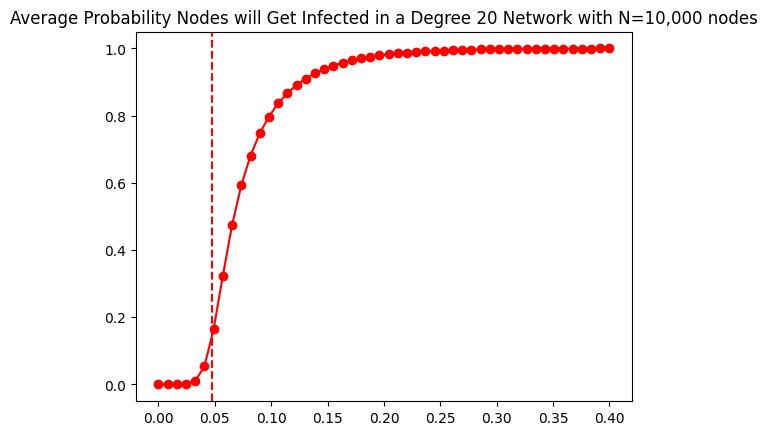

In [ ]:
def probability_nodes_never_infected(net, lambd, num_iterations=10):
    adj_matr = net.get_adjacency_matrix()
    s_vals = generate_uniform_random_numbers(net.num_nodes)
    for _ in range(num_iterations):
        for i in range(net.num_nodes):
            ctr = 1
            neighbours = net.neighbors(i)
            for neighbour in neighbours:
                ctr *= (1-lambd+s_vals[neighbour]*lambd)**adj_matr[i][neighbour]

            s_vals[i] = ctr
    return s_vals



def process_and_plot_x_i(mean_degree, color, label):
    klist_poiss = generate_poisson_variables(10000, mean_degree)
    net_poiss = gen_config(10000, klist_poiss)
    largest_eigenvalue, _ = eigsh(net_poiss.get_adjacency_matrix().astype(float), k=1, which='LA')
    largest_eigenvalue = largest_eigenvalue[0]

    lambdas = np.linspace(0, 0.4, 50)
    avg_x_vals = []
    for lambd in lambdas:
        avg_x_vals.append(1 - np.mean(probability_nodes_never_infected(net_poiss, lambd, 5)))

    plt.plot(lambdas, avg_x_vals, marker='o', linestyle='-', color=color, label=f"{label} (Mean Degree = {mean_degree})")
    plt.axvline(x=1/largest_eigenvalue, color=color, linestyle='--', label=f'1/Largest Eigenvalue = {1/largest_eigenvalue:.4f}')
    plt.title("Average Probability Nodes will Get Infected in a Degree 20 Network with N=10,000 nodes")

process_and_plot_x_i(20, 'red', 'Poisson Config Model')

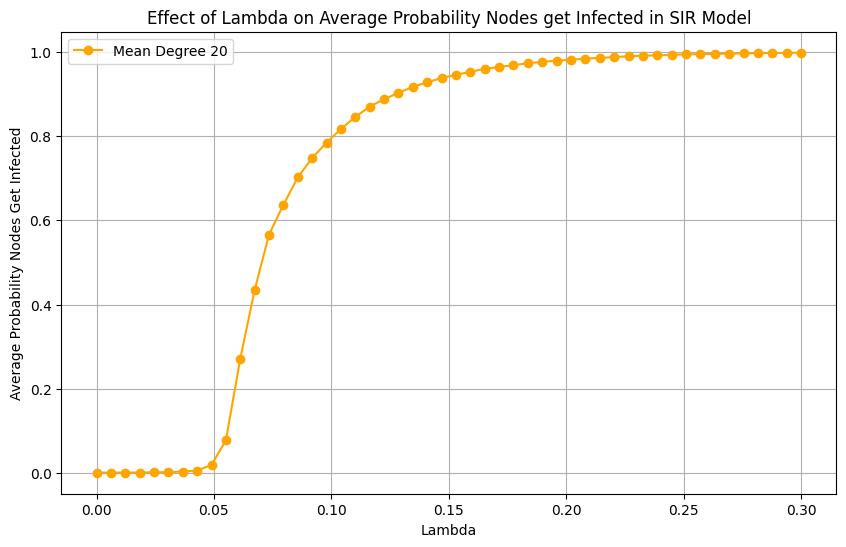

In [ ]:

num_iterations = 30
num_time_steps = 30
q=0.001
lambdas = np.linspace(0, 0.3, 50)

vals_twenty = []


klist_poiss_twenty = generate_poisson_variables(10000, 20)

net_poiss_twenty = gen_config(10000, klist_poiss_twenty)

sir_model_twenty = SIR(net_poiss_twenty)
means=[]

for lamb in (lambdas):
  ls_twenty = []
  vals = np.zeros(10000)
  for i in range(num_iterations):
    sir_model_twenty.init_states(q)


    sir_history_twenty = sir_model_twenty.simulate_sir(lamb, num_time_steps)
    array = np.array(sir_history_twenty[num_time_steps-1])
    transformed_array = np.where(array == 2, 1, 0)
    vals = vals + transformed_array
  vals_twenty.append(vals/num_iterations)
  means.append(np.mean(vals)/num_iterations)

plt.figure(figsize=(10, 6))

plt.plot(lambdas, means, marker='o', linestyle='-', color='orange', label="Mean Degree 20")

plt.xlabel('Lambda')
plt.ylabel('Average Probability Nodes Get Infected')
plt.title('Effect of Lambda on Average Probability Nodes get Infected in SIR Model')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(lambdas, means, marker='o', linestyle='-', color='orange', label="Mean Degree 20")

plt.xlabel('Lambda')
plt.ylabel('Average Probability Nodes Get Infected')
plt.title('Effect of Lambda on Average Probability Nodes get Infected in SIR Model')
plt.legend()
plt.grid(True)
plt.show()

1.0
4.040816326530612
7.081632653061225
10.122448979591837
13.16326530612245
16.20408163265306
19.244897959183675
22.285714285714285
25.3265306122449
28.367346938775512
31.408163265306122
34.44897959183673
37.48979591836735
40.53061224489796
43.57142857142857
46.61224489795919
49.6530612244898
52.69387755102041
55.734693877551024
58.775510204081634
61.816326530612244
64.85714285714286
67.89795918367346
70.93877551020408
73.9795918367347
77.0204081632653
80.06122448979592
83.10204081632654
86.14285714285714
89.18367346938776
92.22448979591837
95.26530612244898
98.3061224489796
101.34693877551021
104.38775510204081
107.42857142857143
110.46938775510205
113.51020408163265
116.55102040816327
119.59183673469389
122.63265306122449
125.6734693877551
128.71428571428572
131.75510204081633
134.79591836734693
137.83673469387756
140.87755102040816
143.91836734693877
146.9591836734694
150.0


Text(0.5, 1.0, 'Average Probability Nodes Infected with $\\lambda \\approx \\lambda_c$ Infected Network with N=10,000 nodes')

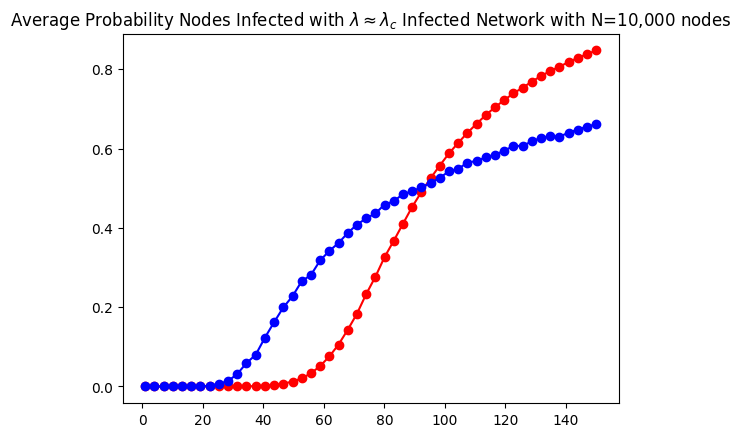

In [ ]:
def probability_nodes_never_infected(net, lambd, num_iterations=10):
    adj_matr = net.get_adjacency_matrix()
    s_vals = generate_uniform_random_numbers(net.num_nodes)
    for _ in range(num_iterations):
        for i in range(net.num_nodes):
            ctr = 1
            neighbours = net.neighbors(i)
            for neighbour in neighbours:
                ctr *= (1-lambd+s_vals[neighbour]*lambd)**adj_matr[i][neighbour]

            s_vals[i] = ctr
    return s_vals




mean_degrees = np.linspace(1, 150, 50)
avg_x_vals_poisson=[]
avg_x_vals_geom=[]
for mean_degree in mean_degrees:
    print(mean_degree)
    klist_poiss = generate_poisson_variables(10000, mean_degree)
    net_poiss = gen_config(10000, klist_poiss)
    largest_eigenvalue_poiss, _ = eigsh(net_poiss.get_adjacency_matrix().astype(float), k=1, which='LA')
    largest_eigenvalue_poiss = largest_eigenvalue_poiss[0]
    lambd = (1/largest_eigenvalue)*1.2
    avg_x_vals_poisson.append(1-np.mean(probability_nodes_never_infected(net_poiss, lambd, 6)))

    klist_geom = generate_geometric_variables(10000, calculate_geom_probability(mean_degree))
    net_geom = gen_config(10000, klist_geom)
    largest_eigenvalue_geom, _ = eigsh(net_geom.get_adjacency_matrix().astype(float), k=1, which='LA')
    largest_eigenvalue_geom = largest_eigenvalue_geom[0]
    lambd = (1/largest_eigenvalue)*1.2
    avg_x_vals_geom.append(1-np.mean(probability_nodes_never_infected(net_geom, lambd, 6)))

plt.plot(mean_degrees, avg_x_vals_poisson, marker='o', linestyle='-', color='Red')
plt.plot(mean_degrees, avg_x_vals_geom, marker='o', linestyle='-', color='Blue')
#plt.axvline(x=1/largest_eigenvalue, color=color, linestyle='--', label=f'1/Largest Eigenvalue = {1/largest_eigenvalue:.4f}')
plt.xlabel('Mean Degree')
plt.ylabel('Average $x_i$')
plt.title("Average Probability Nodes Infected with $\\lambda \\approx 1.2 \\lambda_c$ Infected Network with N=10,000 nodes")


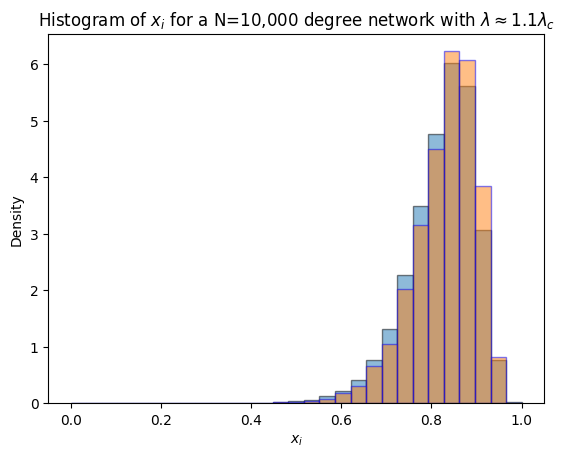

In [ ]:


num_iterations = 500
num_time_steps = 40
q=0.001
lamb = 0.105

vals_twenty = []


klist_poiss_twenty = generate_poisson_variables(10000, 20)

net_poiss_twenty = gen_config(10000, klist_poiss_twenty)

sir_model_twenty = SIR(net_poiss_twenty)

vals = np.zeros(10000)
for i in range(num_iterations):
    sir_model_twenty.init_states(q)


    sir_history_twenty = sir_model_twenty.simulate_sir(lamb, num_time_steps)
    array = np.array(sir_history_twenty[num_time_steps-1])
    transformed_array = np.where(array == 2, 1, 0)
    vals = vals + transformed_array

vals_poiss = vals/ num_iterations


def probability_nodes_never_infected(net, lambd, num_iterations=10):
    adj_matr = net.get_adjacency_matrix()
    s_vals = generate_uniform_random_numbers(net.num_nodes)
    for _ in range(num_iterations):
        for i in range(net.num_nodes):
            ctr = 1
            neighbours = net.neighbors(i)
            for neighbour in neighbours:
                ctr *= (1-lambd+s_vals[neighbour]*lambd)**adj_matr[i][neighbour]

            s_vals[i] = ctr
    return s_vals

prob_poiss = np.ones(10000) - np.array(probability_nodes_never_infected(net_poiss_twenty, lamb, 10))

bin_vals = np.linspace(0, 1, 30)
plt.hist(vals_poiss, bins=bin_vals, edgecolor='black', density=True, alpha = 0.5, label='Simulated')
plt.hist(prob_poiss, bins=bin_vals, edgecolor='blue', density=True, alpha = 0.5, label='Message Passing')
plt.title('Histogram of $x_i$ for a N=10,000 degree network with $\\lambda \\approx 1.1\\lambda_c$')
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.show()

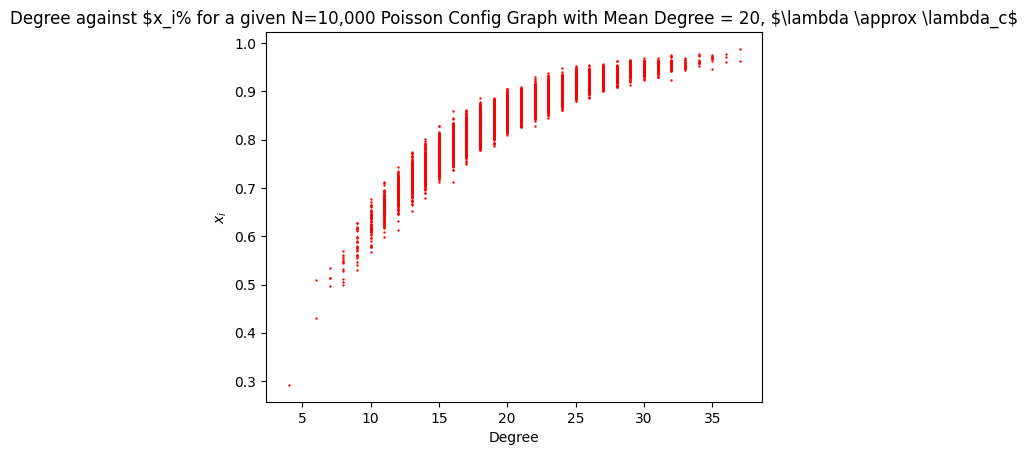

In [ ]:
plt.scatter(net_poiss_twenty.degrees(), vals_poiss, s=0.5, color='Red')
plt.xlabel('Degree')
plt.ylabel('$x_i$')
plt.title('Degree against $x_i$ for a given N=10,000 Poisson Config Graph with Mean Degree = 20, $\\lambda = 11$')
plt.show()

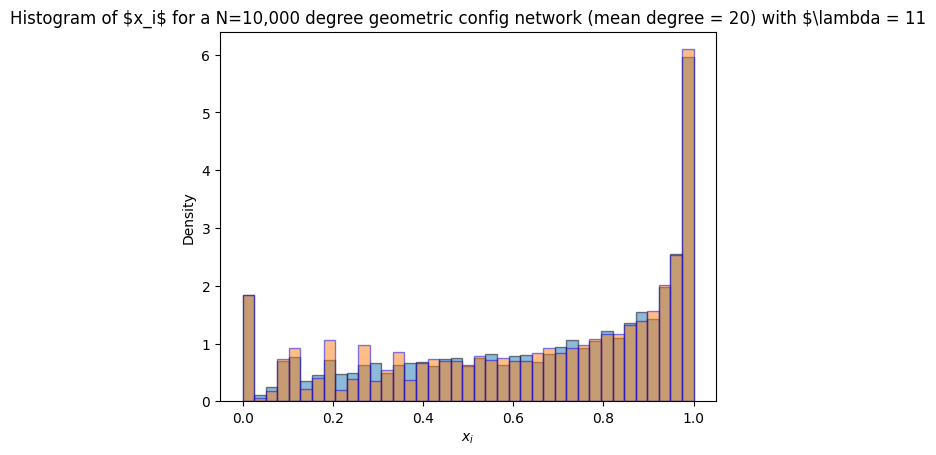

In [ ]:

num_iterations = 300
num_time_steps = 40
q=0.001
lamb = 0.105

vals_twenty = []


klist_geom_twenty = generate_geometric_variables(10000, calculate_geom_probability(20))

net_geom_twenty = gen_config(10000, klist_geom_twenty)

sir_model_twenty = SIR(net_geom_twenty)

vals = np.zeros(10000)
for i in range(num_iterations):
    sir_model_twenty.init_states(q)


    sir_history_twenty = sir_model_twenty.simulate_sir(lamb, num_time_steps)
    array = np.array(sir_history_twenty[num_time_steps-1])
    transformed_array = np.where(array == 2, 1, 0)
    vals = vals + transformed_array

vals_geom = vals/ num_iterations

prob_geom = np.ones(10000) - np.array(probability_nodes_never_infected(net_geom_twenty, lamb, 10))

bin_vals = np.linspace(0, 1, 40)
plt.hist(vals_geom, bins=bin_vals, edgecolor='black', density=True, alpha = 0.5, label='Simulated')
plt.hist(prob_geom, bins=bin_vals, edgecolor='blue', density=True, alpha = 0.5, label='Message Passing')
plt.title('Histogram of $x_i$ for a N=10,000 degree geometric config network (mean degree = 20) with $\\lambda = 11')
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.show()

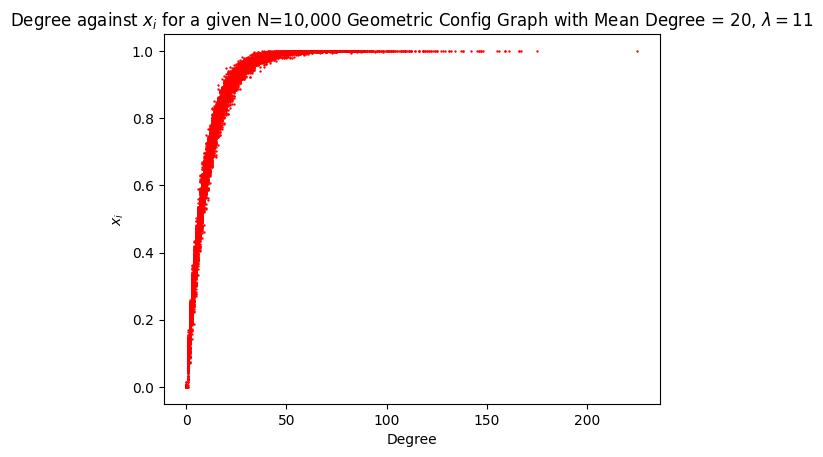

In [ ]:
plt.scatter(net_geom_twenty.degrees(), vals_geom, s=0.5, color='Red')
plt.xlabel('Degree')
plt.ylabel('$x_i$')
plt.title('Degree against $x_i$ for a given N=10,000 Geometric Config Graph with Mean Degree = 20, $\\lambda = 11$')
plt.show()

10000
10000


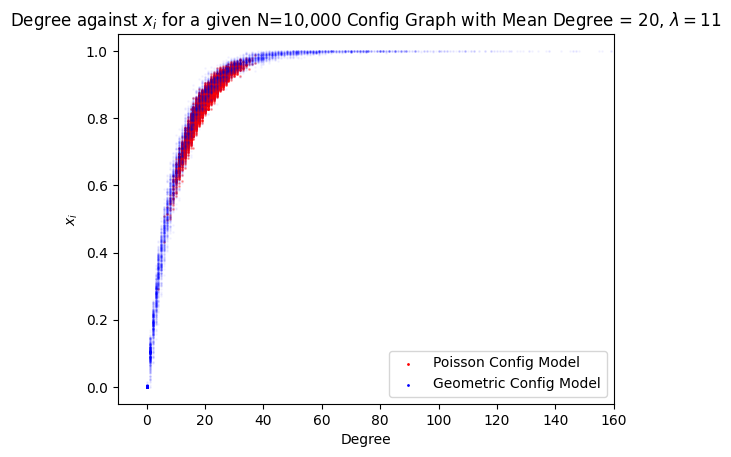

In [ ]:
print(len(vals_poiss))
print(len(vals_geom))
plt.scatter(net_poiss_twenty.degrees(), vals_poiss, s=1, color='Red', alpha=0.3)
plt.scatter(net_geom_twenty.degrees(), vals_geom, s=1, color='Blue', alpha=0.03)
plt.scatter([], [], s=1, color='Red', label="Poisson Config Model", alpha=1)  # Dummy scatter for legend
plt.scatter([], [], s=1, color='Blue', label="Geometric Config Model", alpha=1)  # Dummy scatter for legend
plt.xlabel('Degree')
plt.ylabel('$x_i$')
plt.xlim(-10, 160)
plt.title('Degree against $x_i$ for a given N=10,000 Config Graph with Mean Degree = 20, $\\lambda = 11$')
plt.legend()
plt.show()

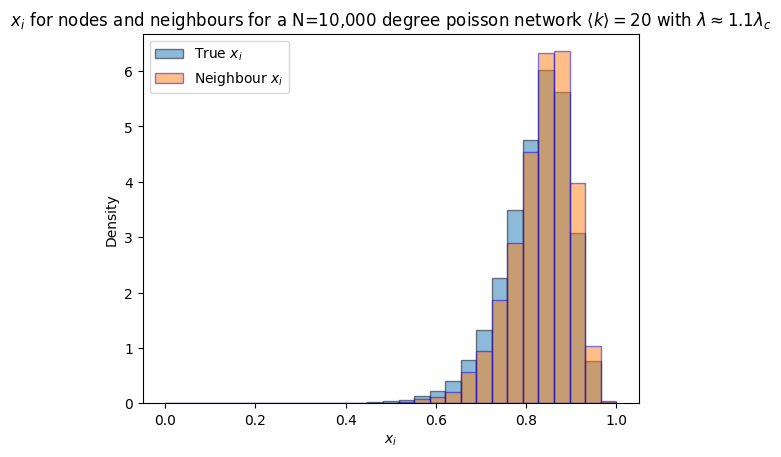

In [ ]:
def disease_paradox(net, x_i, num_samples=1000):
    neighbors_x_i = []
    adj_matrix = net.get_adjacency_matrix()

    for _ in range(num_samples):
        random_node = random.randint(0, adj_matrix.shape[0] - 1)
        neighbors = np.where(adj_matrix[random_node] == 1)[0]

        if len(neighbors) > 0:
            random_neighbor = random.choice(neighbors)
            neighbors_x_i.append(x_i[random_neighbor])

    return neighbors_x_i


neighbours_x_i_poiss = disease_paradox(net_poiss_twenty, vals_poiss, 10000)

bin_vals = np.linspace(0, 1, 30)
plt.hist(vals_poiss, bins=bin_vals, edgecolor='black', density=True, alpha = 0.5, label='True $x_i$')
plt.hist(neighbours_x_i_poiss, bins=bin_vals, edgecolor='blue', density=True, alpha = 0.5, label='Neighbour $x_i$')
plt.title('$x_i$ for nodes and neighbours for a N=10,000 degree poisson network $\\langle k \\rangle = 20$ with $\\lambda \\approx 1.1\\lambda_c$')
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
print(np.mean(vals_poiss))
print(np.mean(neighbours_x_i_poiss))

0.8213547999999999
0.836082


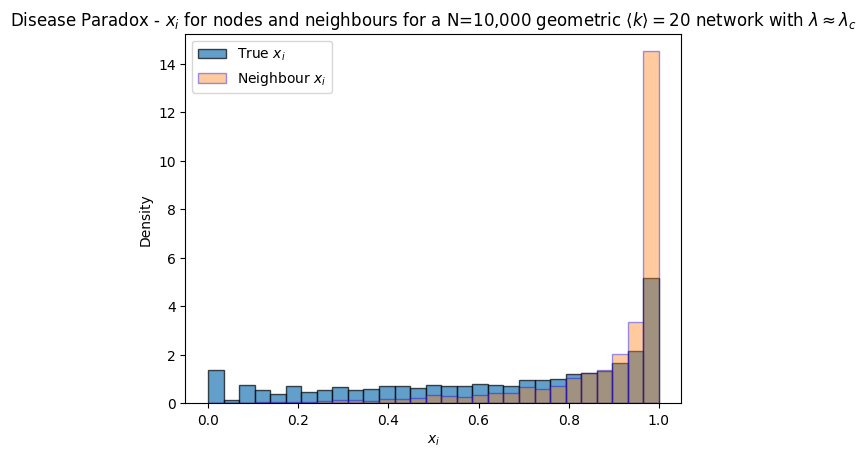

0.647425
0.8862633563796355


In [ ]:
neighbours_x_i_geom = disease_paradox(net_geom_twenty, vals_geom, 10000)

bin_vals = np.linspace(0, 1, 30)
plt.hist(vals_geom, bins=bin_vals, edgecolor='black', density=True, alpha = 0.7, label='True $x_i$')
plt.hist(neighbours_x_i_geom, bins=bin_vals, edgecolor='blue', density=True, alpha = 0.4, label='Neighbour $x_i$')
plt.title('Disease Paradox - $x_i$ for nodes and neighbours for a N=10,000 geometric $\\langle k \\rangle = 20 $ network with $\\lambda \\approx \\lambda_c$')
plt.xlabel('$x_i$')
plt.ylabel('Density')
plt.legend()
plt.show()
print(np.mean(vals_geom))
print(np.mean(neighbours_x_i_geom))


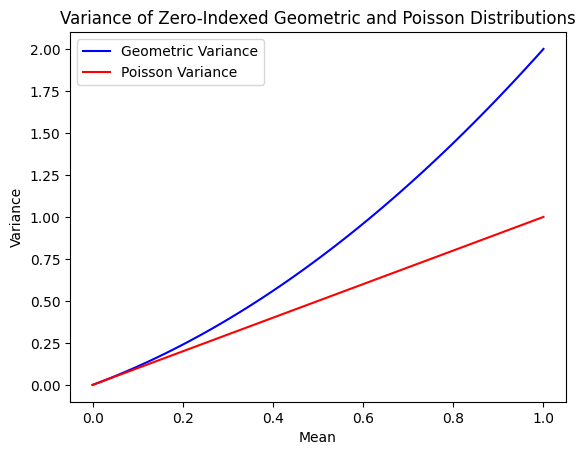

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_geom_probability(mean):
    if mean < 0:
        raise ValueError("Mean must be a positive number.")
    p = 1 / (mean + 1)
    return p

def poisson_variance(mean):
    return mean

means = np.linspace(0, 1, 100)


geom_variances = [geometric_variance(mean) for mean in means]
poisson_variances = [poisson_variance(mean) for mean in means]


plt.plot(means, geom_variances, label='Geometric Variance', color='blue')
plt.plot(means, poisson_variances, label='Poisson Variance', color='red')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Variance of Zero-Indexed Geometric and Poisson Distributions')
plt.legend()
plt.show()


In [ ]:
klist_poiss_twenty = generate_poisson_variables(10000, 40)

net_poiss_twenty = gen_config(10000, klist_poiss_twenty)
vaccination_rates = np.linspace(0, 0.9, 10)
nets = []
for val in vaccination_rates:
    adj, _ = net_poiss_twenty.vaccinate_nodes_remove(val)
    new_net = Network(adj.shape[1])
    new_net.set_connections_from_adjacency_matrix(adj)
    print(new_net.mean_degree())
    nets.append(new_net)

39.8616
35.86244444444444
31.98475
27.899428571428572
24.083
19.8608
15.9515
11.970666666666666
8.07
4.186


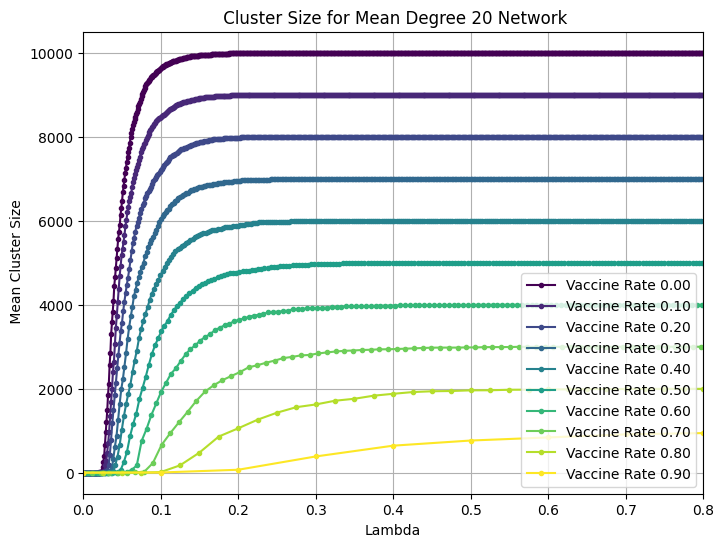

In [ ]:
import matplotlib.cm as cm

means_for_vaccine_orig = []
std_for_vaccine_orig = []
lambdas_orig = []
for net in nets:
    sir = superEfficientSIR(net, 200)
    means, std = sir.average_cluster_sizes()
    means_for_vaccine_orig.append(means)
    std_for_vaccine_orig.append(std)
    num_edges = len(net.edge_list())
    lambdas_orig.append(np.linspace(0, 1, num_edges//200+1))



plt.figure(figsize=(8, 6))

colors = cm.viridis(np.linspace(0, 1, len(means_for_vaccine_orig)))


for i, (means, color) in enumerate(zip(means_for_vaccine_orig, colors)):
    try:
        plt.plot(lambdas_orig[i], np.array(means), marker='o', color=color, markersize=3, label="Vaccine Rate {:.2f}".format(vaccination_rates[i]))
    except:
        continue


plt.xlabel('Lambda')
plt.ylabel(' Mean Cluster Size')
plt.xlim(0, 0.8)
plt.title(' Cluster Size for Mean Degree 20 Network')
plt.legend()
plt.grid(True)
plt.show()



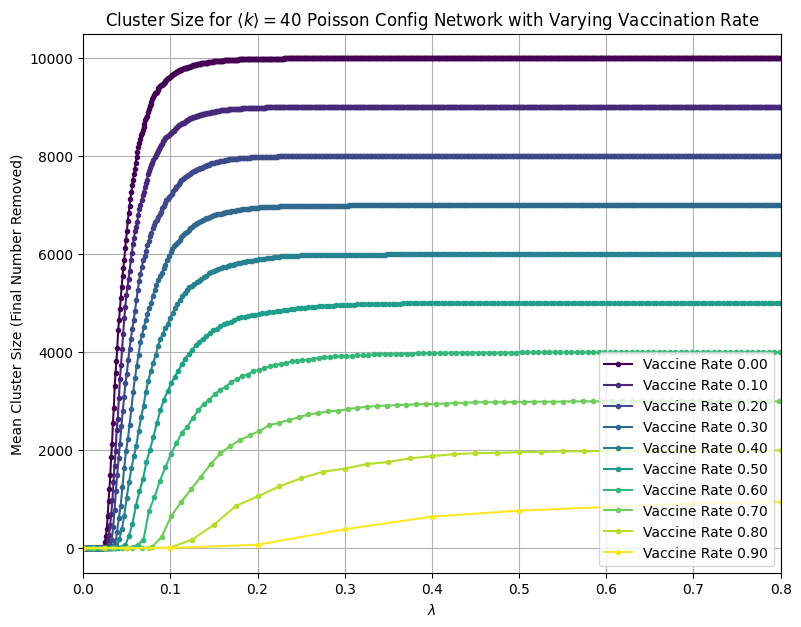

In [ ]:

plt.figure(figsize=(9, 7))
colors = cm.viridis(np.linspace(0, 1, len(means_for_vaccine_orig)))


for i, (means, color) in enumerate(zip(means_for_vaccine_orig, colors)):
    try:
        plt.plot(lambdas_orig[i], np.array(means), marker='o', color=color, markersize=3, label="Vaccine Rate {:.2f}".format(vaccination_rates[i]))
    except:
        continue

plt.xlabel('$\\lambda$')
plt.ylabel('Mean Cluster Size (Final Number Removed)')
plt.xlim(0, 0.8)
plt.title('Cluster Size for $\\langle k \\rangle=40 $ Poisson Config Network with Varying Vaccination Rate')
plt.legend()
plt.grid(True)
plt.show()

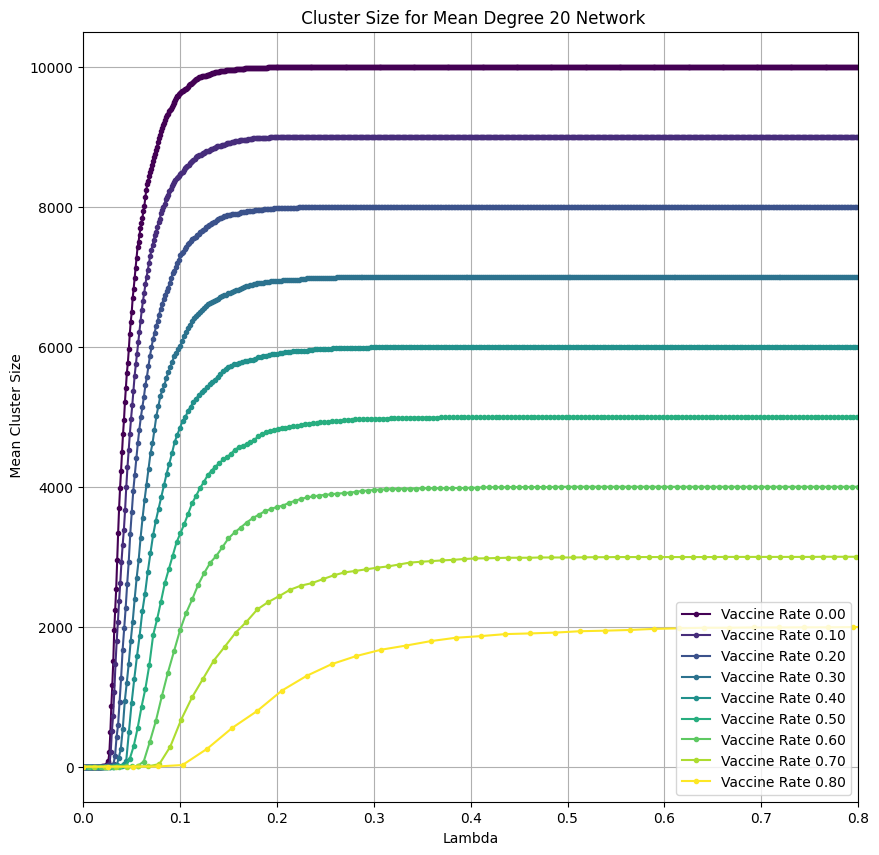

In [ ]:
plt.figure(figsize=(10, 10))
for i, (means, color) in enumerate(zip(means_for_vaccine_orig, colors)):
    try:
        plt.plot(lambdas_orig[i], np.array(means), marker='o', color=color, markersize=3, label="Vaccine Rate {:.2f}".format(vaccination_rates[i]))
    except:
        continue


plt.xlabel('Lambda')
plt.ylabel(' Mean Cluster Size')
plt.xlim(0, 0.8)
plt.title(' Cluster Size for Mean Degree 20 Network')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
nets_2 = []
for val in vaccination_rates:
    adj = net_poiss_twenty.vaccinate_friends_remove(val)
    new_net = Network(adj.shape[1])
    new_net.set_connections_from_adjacency_matrix(adj)
    print(new_net.mean_degree())
    nets_2.append(new_net)

20.0326
17.872666666666667
15.59525
13.535142857142857
11.373333333333333
9.3832
7.2555
5.304666666666667
3.312


171


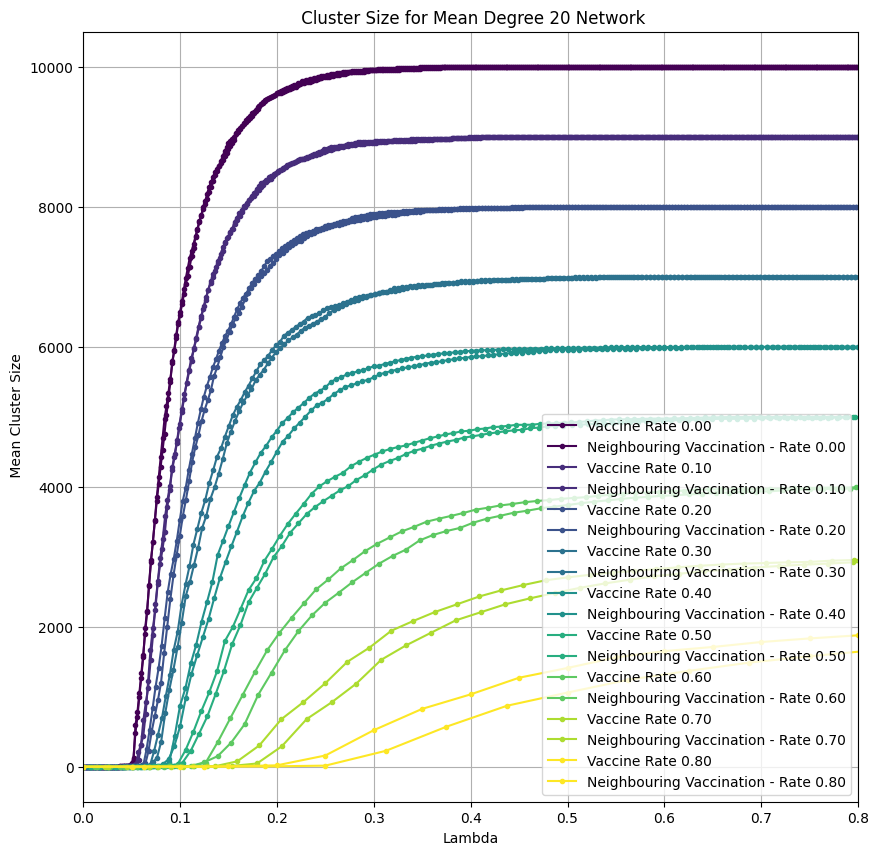

In [ ]:
import matplotlib.cm as cm

means_for_vaccine_friend = []
std_for_vaccine_friend = []
lambdas_friend = []
for net in nets_2:
    sir = superEfficientSIR(net, 200)
    means, std = sir.average_cluster_sizes()
    means_for_vaccine_friend.append(means)
    std_for_vaccine_friend.append(std)
    num_edges = len(net.edge_list())
    lambdas_friend.append(np.linspace(0, 1, num_edges//200+1))



plt.figure(figsize=(10, 10))

colors = cm.viridis(np.linspace(0, 1, len(means_for_vaccine_friend)))
print(len(lambdas[4]))


for i, (means, means_fri, color) in enumerate(zip(means_for_vaccine_orig, means_for_vaccine_friend, colors)):
    try:
        plt.plot(lambdas_orig[i], np.array(means), marker='o', color=color, markersize=3, label="Vaccine Rate {:.2f}".format(vaccination_rates[i]))
        plt.plot(lambdas_friend[i], np.array(means_fri), marker='o', color=color, markersize=3, label="Neighbouring Vaccination - Rate {:.2f}".format(vaccination_rates[i]))
    except:
        continue


plt.xlabel('Lambda')
plt.ylabel(' Mean Cluster Size')
plt.xlim(0, 0.8)
plt.title(' Cluster Size for Mean Degree 20 Network')
plt.legend()
plt.grid(True)
plt.show()

171


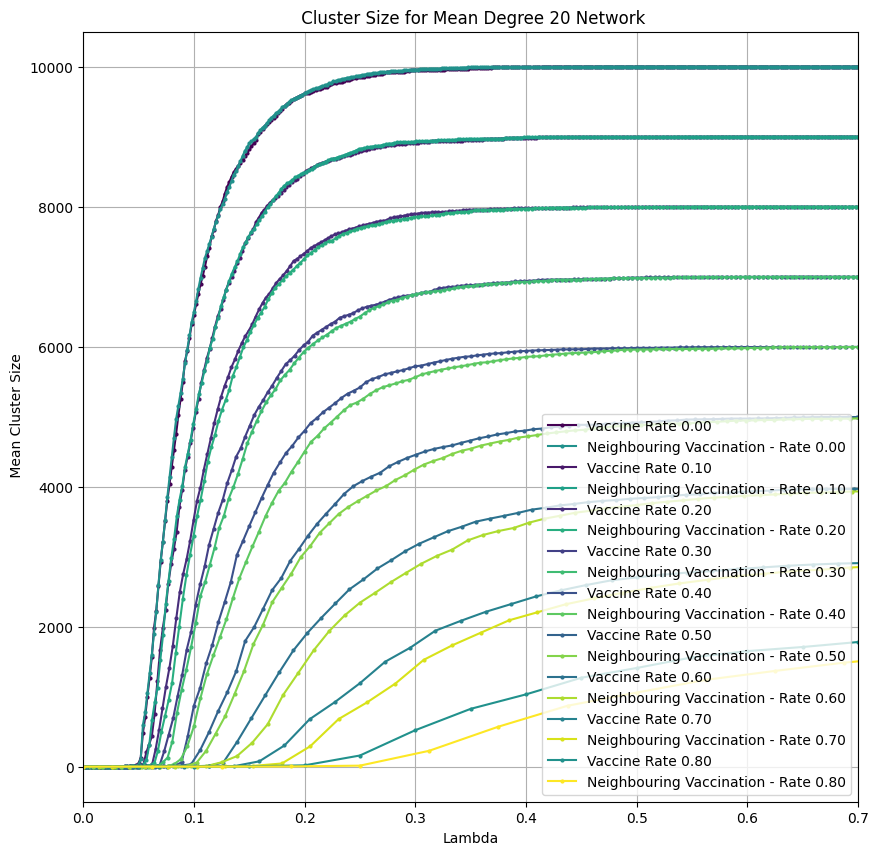

In [ ]:
plt.figure(figsize=(10, 10))

colors_1 = cm.viridis(np.linspace(0, 0.5, len(means_for_vaccine_orig)))
colors_2 = cm.viridis(np.linspace(0.5, 1, len(means_for_vaccine_friend)))
print(len(lambdas[4]))


for i, (means, means_fri, color_1, color_2) in enumerate(zip(means_for_vaccine_orig, means_for_vaccine_friend, colors_1, colors_2)):
    try:
        plt.plot(lambdas_orig[i], np.array(means), marker='o', color=color_1, markersize=2, label="Vaccine Rate {:.2f}".format(vaccination_rates[i]))
        plt.plot(lambdas_friend[i], np.array(means_fri), marker='o', color=color_2, markersize=2, label="Neighbouring Vaccination - Rate {:.2f}".format(vaccination_rates[i]))
    except:
        continue


plt.xlabel('Lambda')
plt.ylabel(' Mean Cluster Size')
plt.xlim(0, 0.7)
plt.title(' Cluster Size for Mean Degree 20 Network')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def probability_nodes_never_infected(net, lambd, num_iterations=10):
    adj_matr = net.get_adjacency_matrix()
    s_vals = generate_uniform_random_numbers(net.num_nodes)
    for _ in range(num_iterations):
        for i in range(net.num_nodes):
            ctr = 1
            neighbours = net.neighbors(i)
            for neighbour in neighbours:
                ctr *= (1-lambd+s_vals[neighbour]*lambd)**adj_matr[i][neighbour]

            s_vals[i] = ctr
    return s_vals



klist_poiss_twenty = generate_poisson_variables(10000, 20)

net_poiss_twenty = gen_config(10000, klist_poiss_twenty)
vaccination_rates = np.linspace(0, 0.6, 7)
nets = []
nets_fri = []
for val in vaccination_rates:
    adj = net_poiss_twenty.vaccinate_nodes_remove(val)
    new_net = Network(adj.shape[1])
    new_net.set_connections_from_adjacency_matrix(adj)
    print(new_net.mean_degree())
    nets.append(new_net)




19.919
17.919120097766914
15.946256717910261
13.972857142857142
11.900016663889351
9.895620875824836
7.9625


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


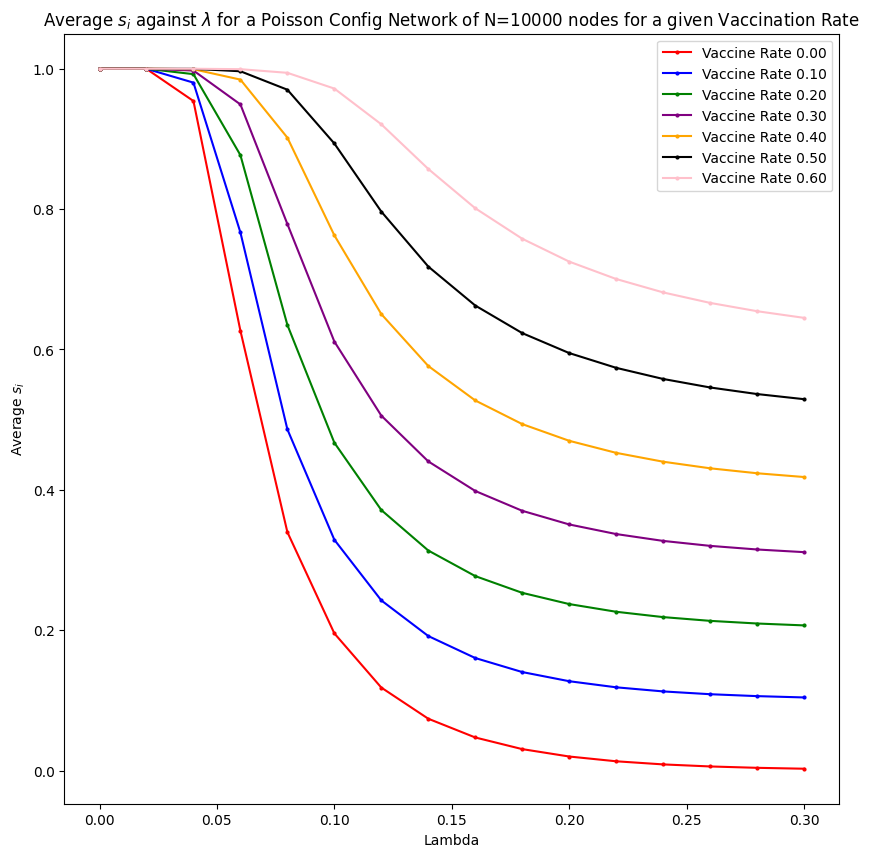

In [ ]:
lambdas = np.linspace(0, 0.3, 16)
colors = ['Red', 'Blue', 'Green', 'Purple', 'Orange', 'Black', 'Pink']
plt.figure(figsize=(10, 10))
for j, net in enumerate(nets):
    probs_not_inf = []
    for i, lambd in enumerate(lambdas):
        print(i)
        s_vals = probability_nodes_never_infected(net, lambd, 5)
        probs_not_inf.append(np.mean(s_vals + [1 for i in range (10000 - len(s_vals))]))
    plt.plot(lambdas, probs_not_inf, marker='o', color=colors[j], markersize=2, label="Vaccine Rate {:.2f}".format(vaccination_rates[j]))
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("Average $s_i$")
plt.title("Average $s_i$ against $\\lambda$ for a Poisson Config Network of N=10000 nodes for a given Vaccination Rate")
plt.show()



In [ ]:

klist_poiss_forty = generate_poisson_variables(10000, 40)

net_poiss_forty = gen_config(10000, klist_poiss_forty)
largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
largest_eigenvalue = largest_eigenvalue[0]
print(1/largest_eigenvalue)
init = len(net_poiss_forty.edge_list())

remove=init//30 - 1

crits=[]
props=[]
for i in range(24):
    largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
    crits.append(1/largest_eigenvalue[0])
    net_poiss_forty.remove_random_connections(remove)
    props.append((i*remove)/init)

net_poiss_forty = gen_config(10000, klist_poiss_forty)
crits_2=[]
props_2=[]
for i in range(24):
    largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
    crits_2.append(1/largest_eigenvalue[0])
    net_poiss_forty.remove_random_connections_friends(remove)
    props_2.append((i*remove)/init)


net_poiss_forty = gen_config(10000, klist_poiss_forty)
adj, _ = net_poiss_forty.vaccinate_nodes_remove(0.5)
net_poiss_forty = Network(adj.shape[1])
new_net.set_connections_from_adjacency_matrix(adj)
init = len(net_poiss_forty.edge_list())
remove=init//30 - 1

crits_e=[]
props_e=[]
for i in range(24):
    print(i)
    largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
    crits_e.append(1/largest_eigenvalue[0])
    net_poiss_forty.remove_random_connections(remove)
    props_e.append((i*remove)/init)

net_poiss_forty = Network(adj.shape[1])
new_net.set_connections_from_adjacency_matrix(adj)
init = len(net_poiss_forty.edge_list())
remove=init//30 - 1

crits_d=[]
props_d=[]
for i in range(24):
    largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
    crits_d.append(1/largest_eigenvalue[0])
    net_poiss_forty.remove_random_connections_friends(remove)
    props_d.append((i*remove)/init)

plt.plot(props, crits, label="Removing Random Node's Connection", color="Blue")
plt.plot(props_2, crits_2, label="Remove Random Friend's Connection", color="Red")
plt.plot(props_e, crits_e, label="Remove Random Node's Connection - 50% Vacc", color="Purple")
plt.plot(props_d, crits_d, label="Remove Random Friend's Connection - 50% Vacc", color="Purple")
plt.xlabel("Proportion of connections removed")
plt.ylabel("$\\lambda_{thres}}$")
plt.title("Plot of $\\lambda_{thre}$ against proportion of connections removed")



0.02446172147058196


NameError: name 'new_net' is not defined

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Text(0.5, 1.0, 'Plot of $\\lambda_{thre}$ against proportion of connections removed also considering 50% vaccination')

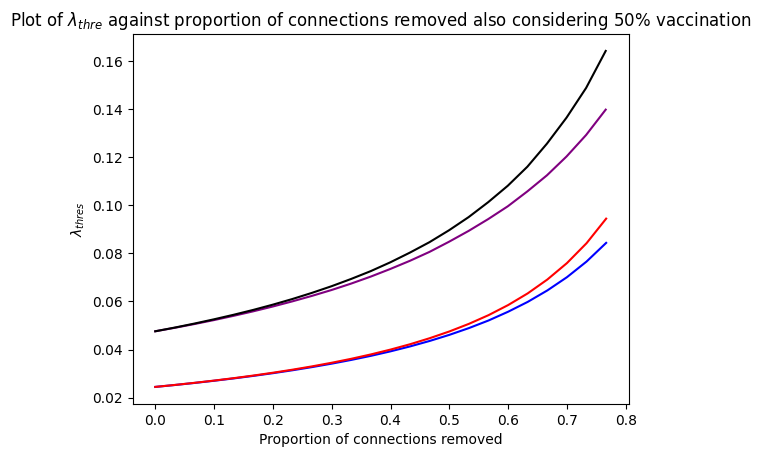

In [ ]:

net_poiss_forty = gen_config(10000, klist_poiss_forty)
adj, _ = net_poiss_forty.vaccinate_nodes_remove(0.5)
net_poiss_forty = Network(adj.shape[1])
net_poiss_forty.set_connections_from_adjacency_matrix(adj)
init = len(net_poiss_forty.edge_list())
remove=init//30 - 1

crits_e=[]
props_e=[]
for i in range(24):
    print(i)
    largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
    crits_e.append(1/largest_eigenvalue[0])
    net_poiss_forty.remove_random_connections(remove)
    props_e.append((i*remove)/init)

net_poiss_forty = Network(adj.shape[1])
net_poiss_forty.set_connections_from_adjacency_matrix(adj)
init = len(net_poiss_forty.edge_list())
remove=init//30 - 1

crits_d=[]
props_d=[]
for i in range(24):
    largest_eigenvalue, _ = eigsh(net_poiss_forty.get_adjacency_matrix().astype(float), k=1, which='LA')
    crits_d.append(1/largest_eigenvalue[0])
    net_poiss_forty.remove_random_connections_friends(remove)
    props_d.append((i*remove)/init)

plt.plot(props, crits, label="Removing Random Node's Connection", color="Blue")
plt.plot(props_2, crits_2, label="Remove Random Friend's Connection", color="Red")
plt.plot(props_e, crits_e, label="Remove Random Node's Connection - 50% Vacc", color="Purple")
plt.plot(props_d, crits_d, label="Remove Random Friend's Connection - 50% Vacc", color="Black")
plt.xlabel("Proportion of connections removed")
plt.ylabel("$\\lambda_{thres}}$")
plt.title("Plot of $\\lambda_{thre}$ against proportion of connections removed also considering 50% vaccination")


[0.04760286196989345, 0.04914841177331164, 0.05081022067181862, 0.05258267285337664, 0.05446688053483612, 0.05648416232986845, 0.058666872290941266, 0.06102120158364707, 0.06357948072794595, 0.06634309622308274, 0.06936776289186034, 0.07261790144551568, 0.07628147533183113, 0.08031634848481331, 0.08466075722936243, 0.089620504762276, 0.09508962444816695, 0.10130738613852473, 0.10813723470435775, 0.11605652137059876, 0.12565427975293725, 0.13646632575130924, 0.14882722596305095, 0.16422504550983943]


Text(0.5, 1.0, 'Plot of $\\lambda_{thresh}$ against proportion of connections removed for Poisson Config Model with $\\langle k \\rangle = 40$')

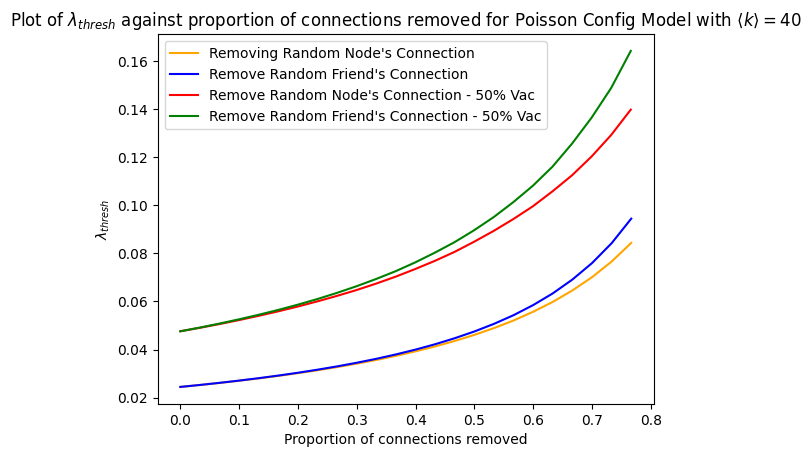

In [ ]:
plt.plot(props[:24], crits[:24], label="Removing Random Node's Connection", color="Orange")
plt.plot(props_2[:24], crits_2[:24], label="Remove Random Friend's Connection", color="Blue")
plt.plot(props_e[:24], crits_e[:24], label="Remove Random Node's Connection - 50% Vac", color="Red")
plt.plot(props_d[:24], crits_d[:24], label="Remove Random Friend's Connection - 50% Vac", color="Green")
print(crits_d)
plt.xlabel("Proportion of connections removed")
plt.ylabel("$\\lambda_{thresh}}$")
plt.legend()
plt.title("Plot of $\\lambda_{thresh}$ against proportion of connections removed for Poisson Config Model with $\\langle k \\rangle = 40$")

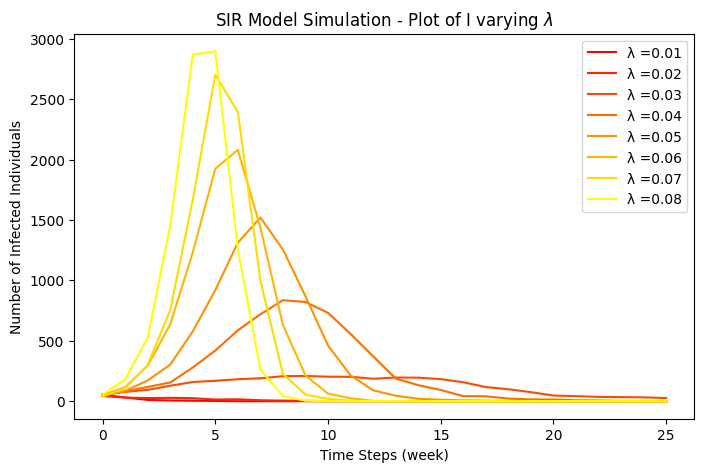

In [ ]:

klist_poiss_twenty = generate_geometric_variables(10000, calculate_geom_probability(40))
net_poiss_forty = gen_config(10000, klist_poiss_forty)


klist_geom_forty = generate_geometric_variables(10000, calculate_geom_probability(40))
net_geom_forty = gen_config(10000, klist_geom_forty)

sir_model_poiss = SIR(net_poiss_forty)
sir_model_geom = SIR(net_geom_forty)


plt.figure(figsize=(8, 5))
lambdas = np.linspace(0.01, 0.08, 8)
num_steps = 25


colors = plt.cm.autumn(np.linspace(0, 1, len(lambdas)))

for idx, lamb in enumerate(lambdas):
    I = []
    sir_model_poiss.init_states(0.005)
    sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
    for state in sir_history_poiss:
        I.append(np.sum(state == 1))
    time_steps = range(len(sir_history_poiss))
    plt.plot(time_steps, I, label='λ =' + str(np.round(lamb ,4)), color=colors[idx])

plt.xlabel('Time Steps (week)')
plt.ylabel('Number of Infected Individuals')
plt.title('SIR Model Simulation - Plot of I varying $\\lambda$')
plt.legend()
plt.show()



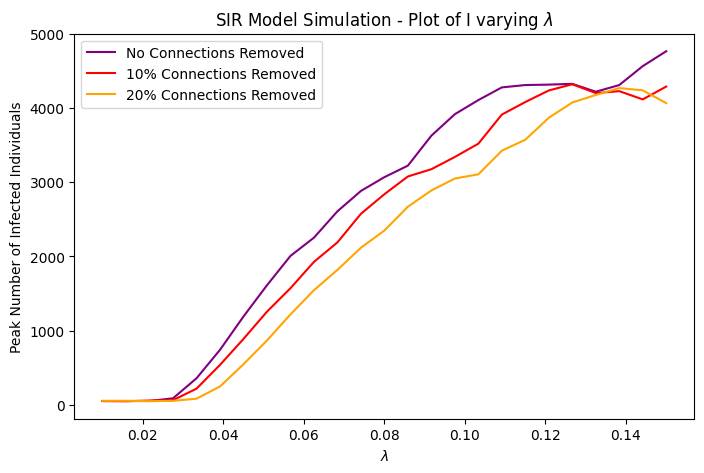

Lambda: 0.01, Average Peak: 47.714285714285715
Lambda: 0.01583333333333333, Average Peak: 47.857142857142854
Lambda: 0.021666666666666667, Average Peak: 48.42857142857143
Lambda: 0.027499999999999997, Average Peak: 85.0
Lambda: 0.03333333333333333, Average Peak: 355.14285714285717
Lambda: 0.03916666666666666, Average Peak: 739.4285714285714
Lambda: 0.045, Average Peak: 1189.2857142857142
Lambda: 0.050833333333333335, Average Peak: 1611.0
Lambda: 0.056666666666666664, Average Peak: 2007.0
Lambda: 0.06249999999999999, Average Peak: 2253.4285714285716
Lambda: 0.06833333333333333, Average Peak: 2609.1428571428573
Lambda: 0.07416666666666666, Average Peak: 2884.0
Lambda: 0.07999999999999999, Average Peak: 3070.285714285714
Lambda: 0.08583333333333332, Average Peak: 3225.714285714286
Lambda: 0.09166666666666666, Average Peak: 3630.1428571428573
Lambda: 0.09749999999999999, Average Peak: 3920.285714285714
Lambda: 0.10333333333333332, Average Peak: 4110.714285714285
Lambda: 0.10916666666666665

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

klist_poiss_twenty = generate_poisson_variables(10000, 40)
net_poiss_forty = gen_config(10000, klist_poiss_forty)

klist_geom_forty = generate_geometric_variables(10000, calculate_geom_probability(40))
net_geom_forty = gen_config(10000, klist_geom_forty)

sir_model_poiss = SIR(net_poiss_forty)
sir_model_geom = SIR(net_geom_forty)

plt.figure(figsize=(8, 5))
lambdas = np.linspace(0.01, 0.15, 25)
num_steps = 25
iterations = 7


colors = plt.cm.autumn(np.linspace(0, 1, len(lambdas)))

average_peaks = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    for _ in range(iterations):
        I = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
        peak_values.append(max(I))
    average_peak = np.mean(peak_values)
    average_peaks.append(average_peak)
    time_steps = range(len(sir_history_poiss))

init = len(net_poiss_forty.edge_list())
net_poiss_forty.remove_random_connections_friends(int(init*0.2))

average_peaks_2 = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    for _ in range(iterations):
        I = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
        peak_values.append(max(I))
    average_peak = np.mean(peak_values)
    average_peaks_2.append(average_peak)
    time_steps = range(len(sir_history_poiss))

average_peaks_3 = []
net_poiss_forty.remove_random_connections_friends(int(init*0.4))

for idx, lamb in enumerate(lambdas):
    peak_values = []
    for _ in range(iterations):
        I = []
        sir_model_poiss.init_states(0.005)  # Placeholder value for q
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
        peak_values.append(max(I))
    average_peak = np.mean(peak_values)
    average_peaks_3.append(average_peak)
    time_steps = range(len(sir_history_poiss))

plt.plot(lambdas, average_peaks, label='No Connections Removed', color='purple')
plt.plot(lambdas, average_peaks_2, label='10% Connections Removed', color='red')
plt.plot(lambdas, average_peaks_3, label='20% Connections Removed', color='orange')


plt.xlabel('$\\lambda$')
plt.ylabel('Peak Number of Infected Individuals')
plt.title('SIR Model Simulation - Plot of I varying $\\lambda$')
plt.legend()
plt.show()



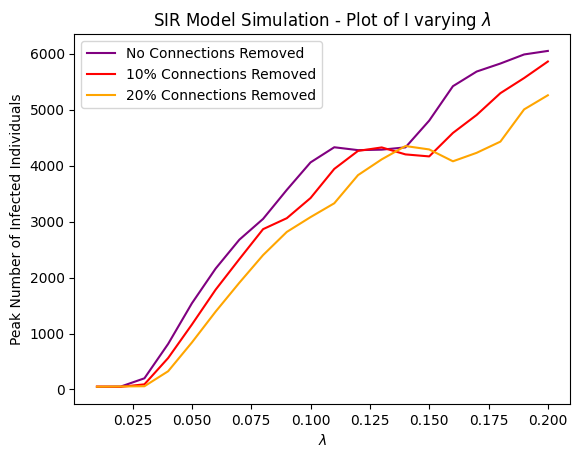

In [ ]:
plt.plot(lambdas, average_peaks, label='No Connections Removed', color='purple')
plt.plot(lambdas, average_peaks_2, label='10% Connections Removed', color='red')
plt.plot(lambdas, average_peaks_3, label='20% Connections Removed', color='orange')


plt.xlabel('$\\lambda$')
plt.ylabel('Peak Number of Infected Individuals')
plt.title('SIR Model Simulation - Plot of I varying $\\lambda$')
plt.legend()
plt.show()

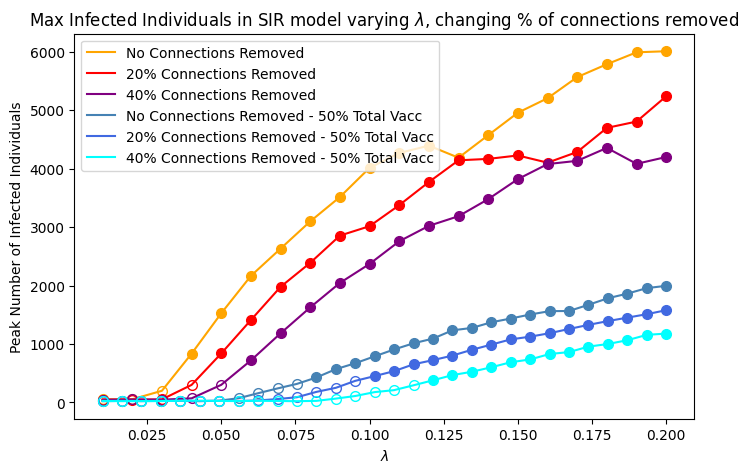

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



klist_poiss_twenty = generate_poisson_variables(10000, 40)
net_poiss_forty = gen_config(10000, klist_poiss_forty)

klist_geom_forty = generate_geometric_variables(10000, calculate_geom_probability(40))


sir_model_poiss = SIR(net_poiss_forty)


plt.figure(figsize=(8, 5))
lambdas = np.linspace(0.01, 0.2, 20)
num_steps = 33
iterations = 5


colors = plt.cm.autumn(np.linspace(0, 1, len(lambdas)))

average_peaks = []
final_R_values_all = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    final_R_values = []
    for _ in range(iterations):
        I = []
        R = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
            R.append(np.sum(state == 2))
        peak_values.append(max(I))
        final_R_values.append(R[-1])
    average_peak = np.mean(peak_values)
    average_peaks.append(average_peak)
    final_R_values_all.append(final_R_values)

plt.plot(lambdas, average_peaks, label='No Connections Removed', color='orange')


for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all[idx])
    if avg_final_R > 6000:
        plt.plot(lamb, average_peaks[idx], 'o', color='orange', markersize=7)
        plt.plot(lamb, average_peaks[idx], 'o', markerfacecolor='none', color='orange', markersize=7)

init = len(net_poiss_forty.edge_list())
net_poiss_forty.remove_random_connections_friends(int(init*0.2))


average_peaks_2 = []
final_R_values_all_2 = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    final_R_values = []
    for _ in range(iterations):
        I = []
        R = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
            R.append(np.sum(state == 2))
        peak_values.append(max(I))
        final_R_values.append(R[-1])
    average_peak = np.mean(peak_values)
    average_peaks_2.append(average_peak)
    final_R_values_all_2.append(final_R_values)


plt.plot(lambdas, average_peaks_2, label='20% Connections Removed', color='red')

for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all_2[idx])
    if avg_final_R > 6000:
        plt.plot(lamb, average_peaks_2[idx], 'o', color='red', markersize=7)  # Solid circle
    else:
        plt.plot(lamb, average_peaks_2[idx], 'o', markerfacecolor='none', color='red', markersize=7)  # Hollow circle


init = len(net_poiss_forty.edge_list())
net_poiss_forty.remove_random_connections_friends(int(init*0.2))


average_peaks_3 = []
final_R_values_all_3 = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    final_R_values = []
    for _ in range(iterations):
        I = []
        R = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
            R.append(np.sum(state == 2))
        peak_values.append(max(I))
        final_R_values.append(R[-1])
    average_peak = np.mean(peak_values)
    average_peaks_3.append(average_peak)
    final_R_values_all_3.append(final_R_values)

plt.plot(lambdas, average_peaks_3, label='40% Connections Removed', color='purple')

for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all_3[idx])
    if avg_final_R > 6000:
        plt.plot(lamb, average_peaks_3[idx], 'o', color='purple', markersize=7)
    else:
        plt.plot(lamb, average_peaks_3[idx], 'o', markerfacecolor='none', color='purple', markersize=7)




klist_poiss_forty= generate_poisson_variables(10000, 40)
net_poiss_forty = gen_config(10000, klist_poiss_forty)

adj, _ = net_poiss_forty.vaccinate_nodes_remove(0.5)
net_poiss_forty = Network(adj.shape[1])
net_poiss_forty.set_connections_from_adjacency_matrix(adj)


sir_model_poiss = SIR(net_poiss_forty)
lambdas = np.linspace(0.01, 0.2, 30)
num_steps = 40
iterations = 5


colors = plt.cm.winter(np.linspace(0, 1, len(lambdas)))

average_peaks = []
final_R_values_all = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    final_R_values = []
    for _ in range(iterations):
        I = []
        R = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
            R.append(np.sum(state == 2))
        peak_values.append(max(I))
        final_R_values.append(R[-1])
    average_peak = np.mean(peak_values)
    average_peaks.append(average_peak)
    final_R_values_all.append(final_R_values)


plt.plot(lambdas, average_peaks, label='No Connections Removed - 50% Total Vacc', color='steelblue')

for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all[idx])
    if avg_final_R > 3000:
        plt.plot(lamb, average_peaks[idx], 'o', color='steelblue', markersize=7)  # Solid circle
    else:
        plt.plot(lamb, average_peaks[idx], 'o', markerfacecolor='none', color='steelblue', markersize=7)  # Hollow circle

init = len(net_poiss_forty.edge_list())
net_poiss_forty.remove_random_connections_friends(int(init*0.2))


average_peaks_2 = []
final_R_values_all_2 = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    final_R_values = []
    for _ in range(iterations):
        I = []
        R = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
            R.append(np.sum(state == 2))
        peak_values.append(max(I))
        final_R_values.append(R[-1])
    average_peak = np.mean(peak_values)
    average_peaks_2.append(average_peak)
    final_R_values_all_2.append(final_R_values)


plt.plot(lambdas, average_peaks_2, label='20% Connections Removed - 50% Total Vacc', color='royalblue')


for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all_2[idx])
    if avg_final_R > 3000:
        plt.plot(lamb, average_peaks_2[idx], 'o', color='royalblue', markersize=7)  # Solid circle
    else:
        plt.plot(lamb, average_peaks_2[idx], 'o', markerfacecolor='none', color='royalblue', markersize=7)  # Hollow circle


init = len(net_poiss_forty.edge_list())
net_poiss_forty.remove_random_connections_friends(int(init*0.2))


average_peaks_3 = []
final_R_values_all_3 = []

for idx, lamb in enumerate(lambdas):
    peak_values = []
    final_R_values = []
    for _ in range(iterations):
        I = []
        R = []
        sir_model_poiss.init_states(0.005)
        sir_history_poiss = sir_model_poiss.simulate_sir(lamb, num_steps)
        for state in sir_history_poiss:
            I.append(np.sum(state == 1))
            R.append(np.sum(state == 2))
        peak_values.append(max(I))
        final_R_values.append(R[-1])
    average_peak = np.mean(peak_values)
    average_peaks_3.append(average_peak)
    final_R_values_all_3.append(final_R_values)


plt.plot(lambdas, average_peaks_3, label='40% Connections Removed - 50% Total Vacc', color='cyan')

for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all_3[idx])
    if avg_final_R > 3000:
        plt.plot(lamb, average_peaks_3[idx], 'o', color='cyan', markersize=7)  # Solid circle
    else:
        plt.plot(lamb, average_peaks_3[idx], 'o', markerfacecolor='none', color='cyan', markersize=7)  # Hollow circle






plt.xlabel('$\\lambda$')
plt.ylabel('Peak Number of Infected Individuals')
plt.title('Max Infected Individuals in SIR model varying $\\lambda$, changing % of connections removed')
plt.legend()
plt.show()

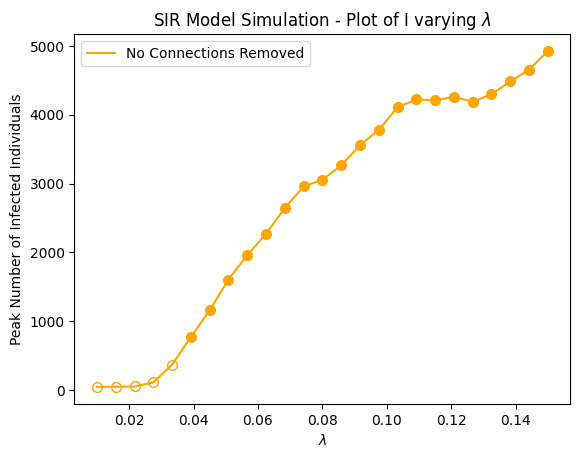

In [ ]:

plt.plot(lambdas, average_peaks, label='No Connections Removed', color='orange')


for idx, lamb in enumerate(lambdas):
    avg_final_R = np.mean(final_R_values_all[idx])
    if avg_final_R > 5000:
        plt.plot(lamb, average_peaks[idx], 'o', color='orange', markersize=7)
    else:
        plt.plot(lamb, average_peaks[idx], 'o', markerfacecolor='none', color='Orange', markersize=7)

plt.xlabel('$\\lambda$')
plt.ylabel('Peak Number of Infected Individuals')
plt.title('SIR Model Simulation - Plot of I varying $\\lambda$')
plt.legend()
plt.show()